In [ ]:
# pm4py 설치
# !pip install --target=$my_path pm4py

## Importing CSV Files


In [1]:
import pandas as pd
import pm4py
import numpy as np

import statistics
import pm4py
import matplotlib.pyplot as plt

from pm4py.objects.log.importer.xes import importer
from pm4py.objects.conversion.log.converter import to_data_frame
from pm4py.algo.filtering.pandas.attributes import attributes_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.objects.log.util import interval_lifecycle
from pm4py.statistics.traces.log import case_arrival
from pm4py.statistics.sojourn_time.log import get as soj_time_get
from pm4py.visualization.graphs import visualizer as graphs_visualizer
from pm4py.util import constants
from pm4py.algo.filtering.log.timestamp import timestamp_filter
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.decisiontree import visualizer as tree_visualizer
from pm4py.algo.decision_mining import algorithm as decision_mining

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/statistics/traces/log/__init__.py:19: UserWarning: pm4py.statistics.traces.log is deprecated. Please use pm4py.statistics.traces.generic.log instead!
  warnings.warn("pm4py.statistics.traces.log is deprecated. Please use pm4py.statistics.traces.generic.log instead!")


In [2]:
df_log = pd.read_csv('financial_log.csv',sep = ',')

# 데이터 설명
본 분석에서 활용되는 이벤트 로그는 네덜란드 은행으로부터 추출된 실제 추출된 로그이며, 이는 은행에서의 대출 신청 프로세스에 관한 것입니다.  
고객이 요청한 금액은 AMOUNT_REQ에 나타나 있으며, Case 속성으로 구성되어 있습니다.  
본 이벤트 로그는 세 개의 서브 이벤트 로그를 합쳐서 구성되었으며, 이는 이벤트 로그 내 Activity의 첫 대문자로 구분할 수 있습니다.  
(분석을 수행할 때, 제공되는 전체 이벤트 로그 단위에서 혹은 각 서브 이벤트 로 그 단위에서 분석해도 무방하니 다양하게 적용하기 바랍니다)

In [3]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262200 entries, 0 to 262199
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Case ID               262200 non-null  int64  
 1   Activity              262200 non-null  object 
 2   Resource              244190 non-null  float64
 3   Complete Timestamp    262200 non-null  object 
 4   Variant               262200 non-null  object 
 5   Variant index         262200 non-null  int64  
 6   lifecycle:transition  262200 non-null  object 
 7   concept:name          262200 non-null  object 
 8   AMOUNT_REQ            262200 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 18.0+ MB


In [4]:
# dataframe, case_id, activity, timestamp(timestamp format 정의) 명시 
event_log_pm4py = pm4py.format_dataframe(df_log, case_id='Case ID', activity_key='Activity',
                                         timestamp_key='Complete Timestamp', timest_format='%Y-%m-%d %H:%M:%S%z')

In [5]:
# Resource data NaN 값들 0으로 바꿔주기 
event_log_pm4py.fillna(0)

Case ID                         Activity  Resource  \
0        173688             A_SUBMITTED-COMPLETE     112.0   
1        173688       A_PARTLYSUBMITTED-COMPLETE     112.0   
2        173688           A_PREACCEPTED-COMPLETE     112.0   
3        173688  W_Completeren aanvraag-SCHEDULE     112.0   
4        173688     W_Completeren aanvraag-START       0.0   
...         ...                              ...       ...   
262195   214376       A_PARTLYSUBMITTED-COMPLETE     112.0   
262196   214376      W_Afhandelen leads-SCHEDULE     112.0   
262197   214376         W_Afhandelen leads-START   11169.0   
262198   214376              A_DECLINED-COMPLETE   11169.0   
262199   214376      W_Afhandelen leads-COMPLETE   11169.0   

                     Complete Timestamp      Variant  Variant index  \
0      2011-10-01 07:38:44.546000+00:00  Variant 613            613   
1      2011-10-01 07:38:44.880000+00:00  Variant 613            613   
2      2011-10-01 07:39:37.906000+00:00  Variant 613            613   
3      2011-10-01 07:39:38.875000+00:00  Variant 613            613   
4      2011-10-01 18:36:46.437000+00:00  Variant 613            613   
...                                 ...          ...            ...   
262195 2012-03-01 07:51:17.423000+00:00    Variant 2              2   
262196 2012-03-01 07:52:01.287000+00:00    Variant 2              2   
262197 2012-03-01 17:26:46.736000+00:00    Variant 2              2   
262198 2012-03-01 17:27:37.118000+00:00    Variant 2              2   
262199 2012-03-01 17:27:41.325000+00:00    Variant 2              2   

       lifecycle:transition  AMOUNT_REQ case:concept:name  \
0                  COMPLETE       20000            173688   
1                  COMPLETE       20000            173688   
2                  COMPLETE       20000            173688   
3                  SCHEDULE       20000            173688   
4                     START       20000            173688   
...                     ...         ...               ...   
262195             COMPLETE       15000            214376   
262196             SCHEDULE       15000            214376   
262197                START       15000            214376   
262198             COMPLETE       15000            214376   
262199             COMPLETE       15000            214376   

                           concept:name                   time:timestamp  \
0                  A_SUBMITTED-COMPLETE 2011-10-01 07:38:44.546000+00:00   
1            A_PARTLYSUBMITTED-COMPLETE 2011-10-01 07:38:44.880000+00:00   
2                A_PREACCEPTED-COMPLETE 2011-10-01 07:39:37.906000+00:00   
3       W_Completeren aanvraag-SCHEDULE 2011-10-01 07:39:38.875000+00:00   
4          W_Completeren aanvraag-START 2011-10-01 18:36:46.437000+00:00   
...                                 ...                              ...   
262195       A_PARTLYSUBMITTED-COMPLETE 2012-03-01 07:51:17.423000+00:00   
262196      W_Afhandelen leads-SCHEDULE 2012-03-01 07:52:01.287000+00:00   
262197         W_Afhandelen leads-START 2012-03-01 17:26:46.736000+00:00   
262198              A_DECLINED-COMPLETE 2012-03-01 17:27:37.118000+00:00   
262199      W_Afhandelen leads-COMPLETE 2012-03-01 17:27:41.325000+00:00   

        @@index  
0             0  
1             1  
2             2  
3             3  
4             4  
...         ...  
262195   262195  
262196   262196  
262197   262197  
262198   262198  
262199   262199  

[262200 rows x 12 columns]

In [6]:
event_log = pm4py.convert_to_event_log(event_log_pm4py)

In [7]:
event_log

[{'attributes': {'concept:name': '173688'}, 'events': [{'Case ID': 173688, 'Activity': 'A_SUBMITTED-COMPLETE', 'Resource': 112.0, 'Complete Timestamp': Timestamp('2011-10-01 07:38:44.546000+0000', tz='UTC'), 'Variant': 'Variant 613', 'Variant index': 613, 'lifecycle:transition': 'COMPLETE', 'AMOUNT_REQ': 20000, 'concept:name': 'A_SUBMITTED-COMPLETE', 'time:timestamp': Timestamp('2011-10-01 07:38:44.546000+0000', tz='UTC'), '@@index': 0}, '..', {'Case ID': 173688, 'Activity': 'W_Valideren aanvraag-COMPLETE', 'Resource': 10629.0, 'Complete Timestamp': Timestamp('2011-10-13 17:37:37.026000+0000', tz='UTC'), 'Variant': 'Variant 613', 'Variant index': 613, 'lifecycle:transition': 'COMPLETE', 'AMOUNT_REQ': 20000, 'concept:name': 'W_Valideren aanvraag-COMPLETE', 'time:timestamp': Timestamp('2011-10-13 17:37:37.026000+0000', tz='UTC'), '@@index': 25}]}, '....', {'attributes': {'concept:name': '214376'}, 'events': [{'Case ID': 214376, 'Activity': 'A_SUBMITTED-COMPLETE', 'Resource': 112.0, 'Comp

In [8]:
# resource 확인 
resources = pm4py.get_event_attribute_values(event_log, "Resource")

In [9]:
# resource 확인 
Activity = pm4py.get_event_attribute_values(event_log, "Activity")

In [10]:
Activity

{'A_SUBMITTED-COMPLETE': 13087,
 'A_PARTLYSUBMITTED-COMPLETE': 13087,
 'A_PREACCEPTED-COMPLETE': 7367,
 'W_Completeren aanvraag-SCHEDULE': 7371,
 'W_Completeren aanvraag-START': 23512,
 'A_ACCEPTED-COMPLETE': 5113,
 'O_SELECTED-COMPLETE': 7030,
 'A_FINALIZED-COMPLETE': 5015,
 'O_CREATED-COMPLETE': 7030,
 'O_SENT-COMPLETE': 7030,
 'W_Nabellen offertes-SCHEDULE': 6634,
 'W_Completeren aanvraag-COMPLETE': 23967,
 'W_Nabellen offertes-START': 22406,
 'W_Nabellen offertes-COMPLETE': 22976,
 'O_SENT_BACK-COMPLETE': 3454,
 'W_Valideren aanvraag-SCHEDULE': 5023,
 'W_Valideren aanvraag-START': 7891,
 'A_REGISTERED-COMPLETE': 2246,
 'A_APPROVED-COMPLETE': 2246,
 'O_ACCEPTED-COMPLETE': 2243,
 'A_ACTIVATED-COMPLETE': 2246,
 'W_Valideren aanvraag-COMPLETE': 7895,
 'O_CANCELLED-COMPLETE': 3655,
 'W_Wijzigen contractgegevens-SCHEDULE': 12,
 'A_DECLINED-COMPLETE': 7635,
 'A_CANCELLED-COMPLETE': 2807,
 'W_Afhandelen leads-SCHEDULE': 4771,
 'W_Afhandelen leads-START': 5897,
 'W_Afhandelen leads-COMPLETE

In [11]:
event_log_pm4py.head(10)

Case ID                         Activity  Resource  \
0   173688             A_SUBMITTED-COMPLETE     112.0   
1   173688       A_PARTLYSUBMITTED-COMPLETE     112.0   
2   173688           A_PREACCEPTED-COMPLETE     112.0   
3   173688  W_Completeren aanvraag-SCHEDULE     112.0   
4   173688     W_Completeren aanvraag-START       NaN   
5   173688              A_ACCEPTED-COMPLETE   10862.0   
6   173688              O_SELECTED-COMPLETE   10862.0   
7   173688             A_FINALIZED-COMPLETE   10862.0   
8   173688               O_CREATED-COMPLETE   10862.0   
9   173688                  O_SENT-COMPLETE   10862.0   

                Complete Timestamp      Variant  Variant index  \
0 2011-10-01 07:38:44.546000+00:00  Variant 613            613   
1 2011-10-01 07:38:44.880000+00:00  Variant 613            613   
2 2011-10-01 07:39:37.906000+00:00  Variant 613            613   
3 2011-10-01 07:39:38.875000+00:00  Variant 613            613   
4 2011-10-01 18:36:46.437000+00:00  Variant 613            613   
5 2011-10-01 18:42:43.308000+00:00  Variant 613            613   
6 2011-10-01 18:45:09.243000+00:00  Variant 613            613   
7 2011-10-01 18:45:09.243000+00:00  Variant 613            613   
8 2011-10-01 18:45:11.197000+00:00  Variant 613            613   
9 2011-10-01 18:45:11.380000+00:00  Variant 613            613   

  lifecycle:transition  AMOUNT_REQ case:concept:name  \
0             COMPLETE       20000            173688   
1             COMPLETE       20000            173688   
2             COMPLETE       20000            173688   
3             SCHEDULE       20000            173688   
4                START       20000            173688   
5             COMPLETE       20000            173688   
6             COMPLETE       20000            173688   
7             COMPLETE       20000            173688   
8             COMPLETE       20000            173688   
9             COMPLETE       20000            173688   

                      concept:name                   time:timestamp  @@index  
0             A_SUBMITTED-COMPLETE 2011-10-01 07:38:44.546000+00:00        0  
1       A_PARTLYSUBMITTED-COMPLETE 2011-10-01 07:38:44.880000+00:00        1  
2           A_PREACCEPTED-COMPLETE 2011-10-01 07:39:37.906000+00:00        2  
3  W_Completeren aanvraag-SCHEDULE 2011-10-01 07:39:38.875000+00:00        3  
4     W_Completeren aanvraag-START 2011-10-01 18:36:46.437000+00:00        4  
5              A_ACCEPTED-COMPLETE 2011-10-01 18:42:43.308000+00:00        5  
6              O_SELECTED-COMPLETE 2011-10-01 18:45:09.243000+00:00        6  
7             A_FINALIZED-COMPLETE 2011-10-01 18:45:09.243000+00:00        7  
8               O_CREATED-COMPLETE 2011-10-01 18:45:11.197000+00:00        8  
9                  O_SENT-COMPLETE 2011-10-01 18:45:11.380000+00:00        9

In [12]:
event_log_pm4py.tail(10)

Case ID                         Activity  Resource  \
262190   214373     W_Nabellen offertes-SCHEDULE   10933.0   
262191   214373  W_Completeren aanvraag-COMPLETE   10933.0   
262192   214373        W_Nabellen offertes-START   11119.0   
262193   214373     W_Nabellen offertes-COMPLETE   11119.0   
262194   214376             A_SUBMITTED-COMPLETE     112.0   
262195   214376       A_PARTLYSUBMITTED-COMPLETE     112.0   
262196   214376      W_Afhandelen leads-SCHEDULE     112.0   
262197   214376         W_Afhandelen leads-START   11169.0   
262198   214376              A_DECLINED-COMPLETE   11169.0   
262199   214376      W_Afhandelen leads-COMPLETE   11169.0   

                     Complete Timestamp       Variant  Variant index  \
262190 2012-03-02 04:22:40.149000+00:00  Variant 4366           4366   
262191 2012-03-02 04:22:41.157000+00:00  Variant 4366           4366   
262192 2012-03-10 20:46:22.700000+00:00  Variant 4366           4366   
262193 2012-03-10 20:50:54.881000+00:00  Variant 4366           4366   
262194 2012-03-01 07:51:16.799000+00:00     Variant 2              2   
262195 2012-03-01 07:51:17.423000+00:00     Variant 2              2   
262196 2012-03-01 07:52:01.287000+00:00     Variant 2              2   
262197 2012-03-01 17:26:46.736000+00:00     Variant 2              2   
262198 2012-03-01 17:27:37.118000+00:00     Variant 2              2   
262199 2012-03-01 17:27:41.325000+00:00     Variant 2              2   

       lifecycle:transition  AMOUNT_REQ case:concept:name  \
262190             SCHEDULE        8500            214373   
262191             COMPLETE        8500            214373   
262192                START        8500            214373   
262193             COMPLETE        8500            214373   
262194             COMPLETE       15000            214376   
262195             COMPLETE       15000            214376   
262196             SCHEDULE       15000            214376   
262197                START       15000            214376   
262198             COMPLETE       15000            214376   
262199             COMPLETE       15000            214376   

                           concept:name                   time:timestamp  \
262190     W_Nabellen offertes-SCHEDULE 2012-03-02 04:22:40.149000+00:00   
262191  W_Completeren aanvraag-COMPLETE 2012-03-02 04:22:41.157000+00:00   
262192        W_Nabellen offertes-START 2012-03-10 20:46:22.700000+00:00   
262193     W_Nabellen offertes-COMPLETE 2012-03-10 20:50:54.881000+00:00   
262194             A_SUBMITTED-COMPLETE 2012-03-01 07:51:16.799000+00:00   
262195       A_PARTLYSUBMITTED-COMPLETE 2012-03-01 07:51:17.423000+00:00   
262196      W_Afhandelen leads-SCHEDULE 2012-03-01 07:52:01.287000+00:00   
262197         W_Afhandelen leads-START 2012-03-01 17:26:46.736000+00:00   
262198              A_DECLINED-COMPLETE 2012-03-01 17:27:37.118000+00:00   
262199      W_Afhandelen leads-COMPLETE 2012-03-01 17:27:41.325000+00:00   

        @@index  
262190   262190  
262191   262191  
262192   262192  
262193   262193  
262194   262194  
262195   262195  
262196   262196  
262197   262197  
262198   262198  
262199   262199

In [13]:
# num of events, num of cases, start and end activities, average of case durations
def basic_data_analysis(event_log):
    num_events = len(event_log)
    num_cases = len(event_log['case:concept:name'].unique())
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    mean_case_durations = np.round(np.mean(pm4py.stats.get_all_case_durations(event_log))/24/60/60, 2)
    print("Number of events: {}\nNumber of cases: {}\nStart activities: {}\nEnd activities: {}\nMean of case durations: {}\n".format(num_events, num_cases, start_activities, end_activities, mean_case_durations))

## (1)  대출 신청 프로세스 관련 총 걸리는 시간은 어느정도 입니까? 

In [14]:
basic_data_analysis(event_log_pm4py)

Number of events: 262200
Number of cases: 13087
Start activities: {'A_SUBMITTED-COMPLETE': 13087}
End activities: {'A_DECLINED-COMPLETE': 3429, 'W_Valideren aanvraag-COMPLETE': 2745, 'W_Afhandelen leads-COMPLETE': 2234, 'W_Completeren aanvraag-COMPLETE': 1939, 'W_Nabellen offertes-COMPLETE': 1289, 'A_CANCELLED-COMPLETE': 655, 'W_Nabellen incomplete dossiers-COMPLETE': 452, 'O_CANCELLED-COMPLETE': 279, 'W_Beoordelen fraude-COMPLETE': 57, 'W_Wijzigen contractgegevens-SCHEDULE': 4, 'W_Valideren aanvraag-START': 2, 'A_REGISTERED-COMPLETE': 1, 'W_Nabellen offertes-START': 1}
Mean of case durations: 8.62



## (1) 승인된 경우, 거절된 경우의 차이가 있습니까?


In [15]:
# 대출 신청 승인된 경우 'A_APPROVED-COMPLETE' : case = 2246, mean of case durations = 16.74 ? A_APPROVED-COMPLETE
filtered_event_log_S = pm4py.filter_eventually_follows_relation(event_log_pm4py, [('A_SUBMITTED-COMPLETE', 'A_APPROVED-COMPLETE')])
basic_data_analysis(filtered_event_log_S)

# 대출 신청 거절된 경우 'A_DECLINED-COMPLETE' : case = 7635, mean of case durations = 2.05
filtered_event_log_D = pm4py.filter_eventually_follows_relation(event_log_pm4py, [('A_SUBMITTED-COMPLETE', 'A_DECLINED-COMPLETE')])
basic_data_analysis(filtered_event_log_D)

# 대출 신청 취소된 경우 'A_CANCELLED-COMPLETE' : case = 2807, mean of case durations = 18.6
filtered_event_log_C = pm4py.filter_eventually_follows_relation(event_log_pm4py, [('A_SUBMITTED-COMPLETE', 'A_CANCELLED-COMPLETE')])
basic_data_analysis(filtered_event_log_C)



Number of events: 99925
Number of cases: 2246
Start activities: {'A_SUBMITTED-COMPLETE': 2246}
End activities: {'W_Valideren aanvraag-COMPLETE': 2046, 'W_Nabellen incomplete dossiers-COMPLETE': 194, 'W_Wijzigen contractgegevens-SCHEDULE': 4, 'A_REGISTERED-COMPLETE': 1, 'W_Nabellen offertes-COMPLETE': 1}
Mean of case durations: 16.74

Number of events: 70432
Number of cases: 7635
Start activities: {'A_SUBMITTED-COMPLETE': 7635}
End activities: {'A_DECLINED-COMPLETE': 3429, 'W_Afhandelen leads-COMPLETE': 2234, 'W_Completeren aanvraag-COMPLETE': 1113, 'W_Valideren aanvraag-COMPLETE': 668, 'W_Nabellen incomplete dossiers-COMPLETE': 86, 'W_Beoordelen fraude-COMPLETE': 57, 'W_Nabellen offertes-COMPLETE': 48}
Mean of case durations: 2.05

Number of events: 79094
Number of cases: 2807
Start activities: {'A_SUBMITTED-COMPLETE': 2807}
End activities: {'W_Nabellen offertes-COMPLETE': 970, 'W_Completeren aanvraag-COMPLETE': 750, 'A_CANCELLED-COMPLETE': 655, 'O_CANCELLED-COMPLETE': 279, 'W_Nabellen

## (5) AMOUNT_REQ에 따른 대출 승인 유무

In [16]:
filtered_event_log_S

Case ID                         Activity  Resource  \
0        173688             A_SUBMITTED-COMPLETE     112.0   
1        173688       A_PARTLYSUBMITTED-COMPLETE     112.0   
2        173688           A_PREACCEPTED-COMPLETE     112.0   
3        173688  W_Completeren aanvraag-SCHEDULE     112.0   
4        173688     W_Completeren aanvraag-START       NaN   
...         ...                              ...       ...   
261800   214277              O_ACCEPTED-COMPLETE   10972.0   
261801   214277             A_ACTIVATED-COMPLETE   10972.0   
261802   214277              A_APPROVED-COMPLETE   10972.0   
261803   214277            A_REGISTERED-COMPLETE   10972.0   
261804   214277    W_Valideren aanvraag-COMPLETE   10972.0   

                     Complete Timestamp       Variant  Variant index  \
0      2011-10-01 07:38:44.546000+00:00   Variant 613            613   
1      2011-10-01 07:38:44.880000+00:00   Variant 613            613   
2      2011-10-01 07:39:37.906000+00:00   Variant 613            613   
3      2011-10-01 07:39:38.875000+00:00   Variant 613            613   
4      2011-10-01 18:36:46.437000+00:00   Variant 613            613   
...                                 ...           ...            ...   
261800 2012-03-09 21:12:28.809000+00:00  Variant 4358           4358   
261801 2012-03-09 21:12:28.809000+00:00  Variant 4358           4358   
261802 2012-03-09 21:12:28.809000+00:00  Variant 4358           4358   
261803 2012-03-09 21:12:28.809000+00:00  Variant 4358           4358   
261804 2012-03-09 21:12:36.714000+00:00  Variant 4358           4358   

       lifecycle:transition  AMOUNT_REQ case:concept:name  \
0                  COMPLETE       20000            173688   
1                  COMPLETE       20000            173688   
2                  COMPLETE       20000            173688   
3                  SCHEDULE       20000            173688   
4                     START       20000            173688   
...                     ...         ...               ...   
261800             COMPLETE       27000            214277   
261801             COMPLETE       27000            214277   
261802             COMPLETE       27000            214277   
261803             COMPLETE       27000            214277   
261804             COMPLETE       27000            214277   

                           concept:name                   time:timestamp  \
0                  A_SUBMITTED-COMPLETE 2011-10-01 07:38:44.546000+00:00   
1            A_PARTLYSUBMITTED-COMPLETE 2011-10-01 07:38:44.880000+00:00   
2                A_PREACCEPTED-COMPLETE 2011-10-01 07:39:37.906000+00:00   
3       W_Completeren aanvraag-SCHEDULE 2011-10-01 07:39:38.875000+00:00   
4          W_Completeren aanvraag-START 2011-10-01 18:36:46.437000+00:00   
...                                 ...                              ...   
261800              O_ACCEPTED-COMPLETE 2012-03-09 21:12:28.809000+00:00   
261801             A_ACTIVATED-COMPLETE 2012-03-09 21:12:28.809000+00:00   
261802              A_APPROVED-COMPLETE 2012-03-09 21:12:28.809000+00:00   
261803            A_REGISTERED-COMPLETE 2012-03-09 21:12:28.809000+00:00   
261804    W_Valideren aanvraag-COMPLETE 2012-03-09 21:12:36.714000+00:00   

        @@index  
0             0  
1             1  
2             2  
3             3  
4             4  
...         ...  
261800   261800  
261801   261801  
261802   261802  
261803   261803  
261804   261804  

[99925 rows x 12 columns]

In [17]:
AR = filtered_event_log_S[filtered_event_log_S.columns.difference(['Case ID','Activity','Complete Timestamp','Variant','@@index'])]
AR = AR.reset_index(drop=True, inplace=False)

In [22]:
AR['case:concept:name'].unique()

<StringArray>
['173688', '173691', '173694', '173718', '173730', '173736', '173739',
 '173751', '173760', '173784',
 ...
 '214052', '214058', '214085', '214139', '214220', '214226', '214238',
 '214250', '214268', '214277']
Length: 2246, dtype: string

In [25]:
ARG = AR.groupby('case:concept:name')

In [36]:
ARGU = ARG['AMOUNT_REQ'].unique()

In [64]:
ARGUD = pd.DataFrame(ARGU)

In [84]:
ARGUD['AMOUNT_REQ'].tolist()[0][0]

20000

In [85]:
a = ARGUD['AMOUNT_REQ'].tolist()

In [92]:
len(a)

2246

In [99]:
aa = []
for i in range(len(a)):
    aa.append(a[i][0])

In [101]:
bb = pd.DataFrame(aa)

In [105]:
cc = pd.DataFrame(bb.value_counts())

In [117]:
cc

0
0         
15000  281
5000   269
10000  226
25000  160
20000  117
...    ...
1200     1
16100    1
15883    1
15800    1
99000    1

[184 rows x 1 columns]

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

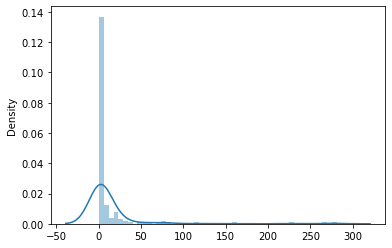

In [106]:
import seaborn as sns
sns.distplot(cc)

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54017 (\N{HANGUL SYLLABLE TIB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/IPython/core/pyla

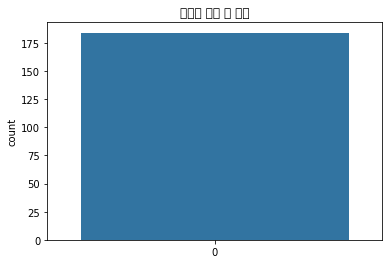

In [112]:
sns.countplot(x= data=cc)
plt.title("요일별 팁을 준 횟수")
plt.show()

In [ ]:
# 안됨 
ARGUD['AMOUNT_REQ'] = ARGUD['AMOUNT_REQ'].str.replace(pat=r'[]', repl=r'')

## (1) 혹시 대출 신청 프로세스 시간이 오래 걸리는 경우가 있다면 이에 대한 원인이 고객인지 혹은 은행인지 확인할 수 있습니까? 원인을 찾아보려고 하였지만, 유효한 결과는 나오지 않아 확인해 볼 수 없었습니다.

In [20]:
# 가장 빠른 timestamp : 2011-10-01 , 가장 늦은 timestamp : 2012-03-15
df_log['Complete Timestamp'].sort_values()

0        2011-10-01 07:38:44.546000+00:00
1        2011-10-01 07:38:44.880000+00:00
2        2011-10-01 07:39:37.906000+00:00
3        2011-10-01 07:39:38.875000+00:00
26       2011-10-01 15:08:58.256000+00:00
                       ...               
256158   2012-03-14 23:59:28.309000+00:00
256159   2012-03-15 00:00:09.680000+00:00
235011   2012-03-15 00:02:03.883000+00:00
246922   2012-03-15 00:04:46.192000+00:00
246923   2012-03-15 00:04:54.681000+00:00
Name: Complete Timestamp, Length: 262200, dtype: datetime64[ns, UTC]

In [21]:
all_case_durations = pm4py.get_all_case_durations(event_log)

In [22]:
# 대출 신청 프로세스 시간이 제일 오래 걸리는 경우
print(all_case_durations[-1])
np.round(np.mean(all_case_durations[-1])/24/60/60, 2)

11855936.012000084


137.22

In [ ]:
enriched_log = interval_lifecycle.assign_lead_cycle_time(event_log)

In [ ]:
enriched_log

[{'attributes': {'concept:name': '173688'}, 'events': [{'Case ID': 173688, 'Activity': 'A_SUBMITTED-COMPLETE', 'Resource': 112.0, 'Complete Timestamp': Timestamp('2011-10-01 07:38:44.546000+0000', tz='UTC'), 'Variant': 'Variant 613', 'Variant index': 613, 'AMOUNT_REQ': 20000, 'concept:name': 'A_SUBMITTED-COMPLETE', '@@index': 0, 'start_timestamp': Timestamp('2011-10-01 07:38:44.546000+0000', tz='UTC'), 'time:timestamp': Timestamp('2011-10-01 07:38:44.546000+0000', tz='UTC'), '@@duration': 0.0, '@@approx_bh_partial_cycle_time': 0, '@@approx_bh_partial_lead_time': 0, '@@approx_bh_overall_wasted_time': 0, '@@approx_bh_this_wasted_time': 0, '@approx_bh_ratio_cycle_lead_time': 1}, '..', {'Case ID': 173688, 'Activity': 'W_Valideren aanvraag-COMPLETE', 'Resource': 10629.0, 'Complete Timestamp': Timestamp('2011-10-13 17:37:37.026000+0000', tz='UTC'), 'Variant': 'Variant 613', 'Variant index': 613, 'AMOUNT_REQ': 20000, 'concept:name': 'W_Valideren aanvraag-COMPLETE', '@@index': 25, 'start_times

In [ ]:
df_enriched_log = pm4py.convert_to_dataframe(enriched_log)

In [ ]:
# lead time : 인스턴스가 활발히 작동했는지 여부를 고려하지 않고 처음부터 끝까지 인스턴스가 작동한 전체 시간
# cycle time : 인스턴스가 실제로 작동한 시간만 고려하여 인스턴스가 처음부터 끝까지 작동한 전체 시간 (이거를 확인해 봐야할 거 같은 느낌!)

# @@approx_bh_partial_cycle_time : 이벤트와 관련된 증분 주기 시간(마지막 이벤트의 주기 시간은 인스턴스의 주기 시간임)
# @@approx_bh_partial_lead_time : 이벤트와 관련된 증분 리드 타임
# @@approx_bh_overall_wasted_time : 부분 리드 타임과 부분 주기 시간 값의 차이
# @@approx_bh_this_wasted_time : '간격' 이벤트에 설명된 활동에 대해서만 시간 낭비
# @@approx_bh_ratio_cycle_lead_time : 증분 유량을 측정합니다(0과 1 사이)

df_enriched_log

Case ID                      Activity  Resource  \
0        173688          A_SUBMITTED-COMPLETE     112.0   
1        173688    A_PARTLYSUBMITTED-COMPLETE     112.0   
2        173688        A_PREACCEPTED-COMPLETE     112.0   
3        173688           A_ACCEPTED-COMPLETE   10862.0   
4        173688           O_SELECTED-COMPLETE   10862.0   
...         ...                           ...       ...   
164501   214373  W_Nabellen offertes-COMPLETE   11119.0   
164502   214376          A_SUBMITTED-COMPLETE     112.0   
164503   214376    A_PARTLYSUBMITTED-COMPLETE     112.0   
164504   214376           A_DECLINED-COMPLETE   11169.0   
164505   214376   W_Afhandelen leads-COMPLETE   11169.0   

                     Complete Timestamp       Variant  Variant index  \
0      2011-10-01 07:38:44.546000+00:00   Variant 613            613   
1      2011-10-01 07:38:44.880000+00:00   Variant 613            613   
2      2011-10-01 07:39:37.906000+00:00   Variant 613            613   
3      2011-10-01 18:42:43.308000+00:00   Variant 613            613   
4      2011-10-01 18:45:09.243000+00:00   Variant 613            613   
...                                 ...           ...            ...   
164501 2012-03-10 20:50:54.881000+00:00  Variant 4366           4366   
164502 2012-03-01 07:51:16.799000+00:00     Variant 2              2   
164503 2012-03-01 07:51:17.423000+00:00     Variant 2              2   
164504 2012-03-01 17:27:37.118000+00:00     Variant 2              2   
164505 2012-03-01 17:27:41.325000+00:00     Variant 2              2   

        AMOUNT_REQ                  concept:name  @@index  \
0            20000          A_SUBMITTED-COMPLETE        0   
1            20000    A_PARTLYSUBMITTED-COMPLETE        1   
2            20000        A_PREACCEPTED-COMPLETE        2   
3            20000           A_ACCEPTED-COMPLETE        5   
4            20000           O_SELECTED-COMPLETE        6   
...            ...                           ...      ...   
164501        8500  W_Nabellen offertes-COMPLETE   262193   
164502       15000          A_SUBMITTED-COMPLETE   262194   
164503       15000    A_PARTLYSUBMITTED-COMPLETE   262195   
164504       15000           A_DECLINED-COMPLETE   262198   
164505       15000   W_Afhandelen leads-COMPLETE   262199   

                        start_timestamp                   time:timestamp  \
0      2011-10-01 07:38:44.546000+00:00 2011-10-01 07:38:44.546000+00:00   
1      2011-10-01 07:38:44.880000+00:00 2011-10-01 07:38:44.880000+00:00   
2      2011-10-01 07:39:37.906000+00:00 2011-10-01 07:39:37.906000+00:00   
3      2011-10-01 18:42:43.308000+00:00 2011-10-01 18:42:43.308000+00:00   
4      2011-10-01 18:45:09.243000+00:00 2011-10-01 18:45:09.243000+00:00   
...                                 ...                              ...   
164501 2012-03-10 20:50:54.881000+00:00 2012-03-10 20:50:54.881000+00:00   
164502 2012-03-01 07:51:16.799000+00:00 2012-03-01 07:51:16.799000+00:00   
164503 2012-03-01 07:51:17.423000+00:00 2012-03-01 07:51:17.423000+00:00   
164504 2012-03-01 17:27:37.118000+00:00 2012-03-01 17:27:37.118000+00:00   
164505 2012-03-01 17:27:41.325000+00:00 2012-03-01 17:27:41.325000+00:00   

        @@duration  @@approx_bh_partial_cycle_time  \
0              0.0                               0   
1              0.0                               0   
2              0.0                               0   
3              0.0                               0   
4              0.0                               0   
...            ...                             ...   
164501         0.0                               0   
164502         0.0                               0   
164503         0.0                               0   
164504         0.0                               0   
164505         0.0                               0   

        @@approx_bh_partial_lead_time  @@approx_bh_overall_wasted_time  \
0                               0.000                            

In [ ]:
df_enriched_log['@@approx_bh_overall_wasted_time'].unique()

# EDA

In [ ]:
# activity 목록 도출
activities = attributes_filter.get_attribute_values(df_log, attribute_key="concept:name")
# resource 목록 도출
resources = attributes_filter.get_attribute_values(df_log, attribute_key='time:timestamp')

In [ ]:
print(activities)

{'W_Completeren aanvraag-COMPLETE': 23967, 'W_Completeren aanvraag-START': 23512, 'W_Nabellen offertes-COMPLETE': 22976, 'W_Nabellen offertes-START': 22406, 'A_PARTLYSUBMITTED-COMPLETE': 13087, 'A_SUBMITTED-COMPLETE': 13087, 'W_Nabellen incomplete dossiers-COMPLETE': 11407, 'W_Nabellen incomplete dossiers-START': 11400, 'W_Valideren aanvraag-COMPLETE': 7895, 'W_Valideren aanvraag-START': 7891, 'A_DECLINED-COMPLETE': 7635, 'W_Completeren aanvraag-SCHEDULE': 7371, 'A_PREACCEPTED-COMPLETE': 7367, 'O_SELECTED-COMPLETE': 7030, 'O_SENT-COMPLETE': 7030, 'O_CREATED-COMPLETE': 7030, 'W_Nabellen offertes-SCHEDULE': 6634, 'W_Afhandelen leads-COMPLETE': 5898, 'W_Afhandelen leads-START': 5897, 'A_ACCEPTED-COMPLETE': 5113, 'W_Valideren aanvraag-SCHEDULE': 5023, 'A_FINALIZED-COMPLETE': 5015, 'W_Afhandelen leads-SCHEDULE': 4771, 'O_CANCELLED-COMPLETE': 3655, 'O_SENT_BACK-COMPLETE': 3454, 'A_CANCELLED-COMPLETE': 2807, 'W_Nabellen incomplete dossiers-SCHEDULE': 2383, 'A_APPROVED-COMPLETE': 2246, 'A_ACTI

In [ ]:
start_activities = start_activities_filter.get_start_activities(df_log)
end_activities = end_activities_filter.get_end_activities(df_log)

In [ ]:
print(start_activities)

{'A_SUBMITTED-COMPLETE': 13087}


In [ ]:
print(end_activities)

{'W_Valideren aanvraag-COMPLETE': 2745, 'W_Wijzigen contractgegevens-SCHEDULE': 4, 'A_DECLINED-COMPLETE': 3429, 'W_Completeren aanvraag-COMPLETE': 1939, 'A_CANCELLED-COMPLETE': 655, 'W_Nabellen incomplete dossiers-COMPLETE': 452, 'W_Afhandelen leads-COMPLETE': 2234, 'W_Nabellen offertes-COMPLETE': 1289, 'W_Beoordelen fraude-COMPLETE': 57, 'O_CANCELLED-COMPLETE': 279, 'A_REGISTERED-COMPLETE': 1, 'W_Nabellen offertes-START': 1, 'W_Valideren aanvraag-START': 2}


## Filtering Event Data

In [ ]:
# basic_data_analysis(event_log_pm4py)와 비슷 
filtered_event_log = pm4py.filter_start_activities(event_log_pm4py, {'A_SUBMITTED-COMPLETE'})

filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'A_DECLINED-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Valideren aanvraag-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Afhandelen leads-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Completeren aanvraag-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Nabellen offertes-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'A_CANCELLED-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Nabellen incomplete dossiers-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'O_CANCELLED-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Beoordelen fraude-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Wijzigen contractgegevens-SCHEDULE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Valideren aanvraag-START'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'A_REGISTERED-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Nabellen offertes-START'})
basic_data_analysis(filtered_event_log)

## Filtering Event Data A

In [ ]:
# basic_data_analysis(event_log_pm4py)와 비슷 
filtered_event_log = pm4py.filter_start_activities(event_log_pm4py, {'A_SUBMITTED-COMPLETE'})

filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'A_DECLINED-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'A_CANCELLED-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'A_REGISTERED-COMPLETE'})
basic_data_analysis(filtered_event_log)

Number of events: 33
Number of cases: 1
Start activities: {'A_SUBMITTED-COMPLETE': 1}
End activities: {'A_REGISTERED-COMPLETE': 1}
Mean of case durations: 12.92


## Filtering Event Data W

In [ ]:
# basic_data_analysis(event_log_pm4py)와 비슷 
filtered_event_log = pm4py.filter_start_activities(event_log_pm4py, {'A_SUBMITTED-COMPLETE'})

filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Valideren aanvraag-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Afhandelen leads-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Completeren aanvraag-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Nabellen offertes-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Nabellen incomplete dossiers-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Beoordelen fraude-COMPLETE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Wijzigen contractgegevens-SCHEDULE'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Valideren aanvraag-START'})
filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'W_Nabellen offertes-START'})
basic_data_analysis(filtered_event_log)

## Filtering Event Data O

In [ ]:
# basic_data_analysis(event_log_pm4py)와 비슷 
filtered_event_log = pm4py.filter_start_activities(event_log_pm4py, {'A_SUBMITTED-COMPLETE'})

filtered_event_log = pm4py.filter_end_activities(event_log_pm4py, {'O_CANCELLED-COMPLETE'})
basic_data_analysis(filtered_event_log)

Number of events: 10775
Number of cases: 279
Start activities: {'A_SUBMITTED-COMPLETE': 279}
End activities: {'O_CANCELLED-COMPLETE': 279}
Mean of case durations: 33.58


## (2) 어떤 작업자들이 업무 효율이 훌륭합니까? (생산성 측면 등)
'W_' 종류의 작업이 작업자에 의해 처리 시작됨  
'W_' 종류의 작업이 작업자에 의해 처리 종료됨 
  
W_Afhandelen leads = W_Fixing incoming lead = 유입 리드 고정  
W_Completeren aanvraag = W_Filling in information for the application = 응용 프로그램에 대한 정보 입력  
W_Valideren aanvraag = W_Assessing the application = 응용 프로그램 평가  
W_Nabellen offertes = W_Calling after sent offers = 오퍼를 보낸 후 전화  
W_Nabellen incomplete dossiers = W_Calling to add missing information to the application = 응용 프로그램에 누락된 정보를 추가하기 위해 전화  


In [16]:
Activity

{'A_SUBMITTED-COMPLETE': 13087,
 'A_PARTLYSUBMITTED-COMPLETE': 13087,
 'A_PREACCEPTED-COMPLETE': 7367,
 'W_Completeren aanvraag-SCHEDULE': 7371,
 'W_Completeren aanvraag-START': 23512,
 'A_ACCEPTED-COMPLETE': 5113,
 'O_SELECTED-COMPLETE': 7030,
 'A_FINALIZED-COMPLETE': 5015,
 'O_CREATED-COMPLETE': 7030,
 'O_SENT-COMPLETE': 7030,
 'W_Nabellen offertes-SCHEDULE': 6634,
 'W_Completeren aanvraag-COMPLETE': 23967,
 'W_Nabellen offertes-START': 22406,
 'W_Nabellen offertes-COMPLETE': 22976,
 'O_SENT_BACK-COMPLETE': 3454,
 'W_Valideren aanvraag-SCHEDULE': 5023,
 'W_Valideren aanvraag-START': 7891,
 'A_REGISTERED-COMPLETE': 2246,
 'A_APPROVED-COMPLETE': 2246,
 'O_ACCEPTED-COMPLETE': 2243,
 'A_ACTIVATED-COMPLETE': 2246,
 'W_Valideren aanvraag-COMPLETE': 7895,
 'O_CANCELLED-COMPLETE': 3655,
 'W_Wijzigen contractgegevens-SCHEDULE': 12,
 'A_DECLINED-COMPLETE': 7635,
 'A_CANCELLED-COMPLETE': 2807,
 'W_Afhandelen leads-SCHEDULE': 4771,
 'W_Afhandelen leads-START': 5897,
 'W_Afhandelen leads-COMPLETE

In [17]:
W_A = df_log['Activity'].unique()
W_A = W_A.tolist()

In [18]:
W_Activity = []
W_Activity.append([W_A[4],W_A[11],W_A[12],W_A[13],W_A[16],W_A[21],W_A[27],W_A[28],W_A[31],W_A[32],W_A[34],W_A[35]])

In [19]:
W_Activity

[['W_Completeren aanvraag-START',
  'W_Completeren aanvraag-COMPLETE',
  'W_Nabellen offertes-START',
  'W_Nabellen offertes-COMPLETE',
  'W_Valideren aanvraag-START',
  'W_Valideren aanvraag-COMPLETE',
  'W_Afhandelen leads-START',
  'W_Afhandelen leads-COMPLETE',
  'W_Nabellen incomplete dossiers-START',
  'W_Nabellen incomplete dossiers-COMPLETE',
  'W_Beoordelen fraude-START',
  'W_Beoordelen fraude-COMPLETE']]

In [142]:
# W의 START와 COMPLETE의 평균이 낮은 Resource 찾기 ('concept:name'만 나오게 다시 생각해보기)

# W_Completeren aanvraag = 15.23 , Resource = 11000
filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'concept:name', {W_Activity[0][0], W_Activity[0][1]}) 
# W_Nabellen offertes = 18.75
# filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'concept:name', {W_Activity[0][2], W_Activity[0][3]})
# # W_Valideren aanvraag = 17.3
# filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'concept:name', {W_Activity[0][4], W_Activity[0][5]})
# # W_Afhandelen leads = 7.34
# filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'concept:name', {W_Activity[0][6], W_Activity[0][7]})
# # W_Nabellen incomplete dossiers = 19.59
# filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'concept:name', {W_Activity[0][8], W_Activity[0][9]})
# # W_Beoordelen fraude = 9.42
# filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'concept:name', {W_Activity[0][10], W_Activity[0][11]})

basic_data_analysis(filtered_event_log)
filtered_event_log.head(10)

Number of events: 236820
Number of cases: 7367
Start activities: {'A_SUBMITTED-COMPLETE': 7367}
End activities: {'W_Valideren aanvraag-COMPLETE': 2745, 'W_Completeren aanvraag-COMPLETE': 1939, 'W_Nabellen offertes-COMPLETE': 1289, 'A_CANCELLED-COMPLETE': 654, 'W_Nabellen incomplete dossiers-COMPLETE': 452, 'O_CANCELLED-COMPLETE': 279, 'W_Wijzigen contractgegevens-SCHEDULE': 4, 'W_Valideren aanvraag-START': 2, 'W_Beoordelen fraude-COMPLETE': 1, 'A_REGISTERED-COMPLETE': 1, 'W_Nabellen offertes-START': 1}
Mean of case durations: 15.23



Case ID                         Activity  Resource  \
0   173688             A_SUBMITTED-COMPLETE     112.0   
1   173688       A_PARTLYSUBMITTED-COMPLETE     112.0   
2   173688           A_PREACCEPTED-COMPLETE     112.0   
3   173688  W_Completeren aanvraag-SCHEDULE     112.0   
4   173688     W_Completeren aanvraag-START       NaN   
5   173688              A_ACCEPTED-COMPLETE   10862.0   
6   173688              O_SELECTED-COMPLETE   10862.0   
7   173688             A_FINALIZED-COMPLETE   10862.0   
8   173688               O_CREATED-COMPLETE   10862.0   
9   173688                  O_SENT-COMPLETE   10862.0   

                Complete Timestamp      Variant  Variant index  \
0 2011-10-01 07:38:44.546000+00:00  Variant 613            613   
1 2011-10-01 07:38:44.880000+00:00  Variant 613            613   
2 2011-10-01 07:39:37.906000+00:00  Variant 613            613   
3 2011-10-01 07:39:38.875000+00:00  Variant 613            613   
4 2011-10-01 18:36:46.437000+00:00  Variant 613            613   
5 2011-10-01 18:42:43.308000+00:00  Variant 613            613   
6 2011-10-01 18:45:09.243000+00:00  Variant 613            613   
7 2011-10-01 18:45:09.243000+00:00  Variant 613            613   
8 2011-10-01 18:45:11.197000+00:00  Variant 613            613   
9 2011-10-01 18:45:11.380000+00:00  Variant 613            613   

  lifecycle:transition  AMOUNT_REQ case:concept:name  \
0             COMPLETE       20000            173688   
1             COMPLETE       20000            173688   
2             COMPLETE       20000            173688   
3             SCHEDULE       20000            173688   
4                START       20000            173688   
5             COMPLETE       20000            173688   
6             COMPLETE       20000            173688   
7             COMPLETE       20000            173688   
8             COMPLETE       20000            173688   
9             COMPLETE       20000            173688   

                      concept:name                   time:timestamp  @@index  
0             A_SUBMITTED-COMPLETE 2011-10-01 07:38:44.546000+00:00        0  
1       A_PARTLYSUBMITTED-COMPLETE 2011-10-01 07:38:44.880000+00:00        1  
2           A_PREACCEPTED-COMPLETE 2011-10-01 07:39:37.906000+00:00        2  
3  W_Completeren aanvraag-SCHEDULE 2011-10-01 07:39:38.875000+00:00        3  
4     W_Completeren aanvraag-START 2011-10-01 18:36:46.437000+00:00        4  
5              A_ACCEPTED-COMPLETE 2011-10-01 18:42:43.308000+00:00        5  
6              O_SELECTED-COMPLETE 2011-10-01 18:45:09.243000+00:00        6  
7             A_FINALIZED-COMPLETE 2011-10-01 18:45:09.243000+00:00        7  
8               O_CREATED-COMPLETE 2011-10-01 18:45:11.197000+00:00        8  
9                  O_SENT-COMPLETE 2011-10-01 18:45:11.380000+00:00        9

In [143]:
W1 = filtered_event_log

In [144]:
W11 = W1[ (W1['concept:name'] == 'W_Completeren aanvraag-START') | (W1['concept:name'] ==  'W_Completeren aanvraag-COMPLETE')]
# W11 = W1[ (W1['concept:name'] == 'W_Nabellen offertes-START') | (W1['concept:name'] ==  'W_Nabellen offertes-COMPLETE')]
# W11 = W1[ (W1['concept:name'] == 'W_Valideren aanvraag-START') | (W1['concept:name'] ==  'W_Valideren aanvraag-COMPLETE')]
# W11 = W1[ (W1['concept:name'] == 'W_Afhandelen leads-START') | (W1['concept:name'] ==  'W_Afhandelen leads-COMPLETE')]
# W11 = W1[ (W1['concept:name'] == 'W_Nabellen incomplete dossiers-START') | (W1['concept:name'] ==  'W_Nabellen incomplete dossiers-COMPLETE')]
# W11 = W1[ (W1['concept:name'] == 'W_Beoordelen fraude-START') | (W1['concept:name'] ==  'W_Beoordelen fraude-COMPLETE')]

In [145]:
W11['concept:name'].unique()

<StringArray>
['W_Completeren aanvraag-START', 'W_Completeren aanvraag-COMPLETE']
Length: 2, dtype: string

In [146]:
W11

Case ID                         Activity  Resource  \
4        173688     W_Completeren aanvraag-START       NaN   
11       173688  W_Completeren aanvraag-COMPLETE       NaN   
30       173691     W_Completeren aanvraag-START       NaN   
31       173691  W_Completeren aanvraag-COMPLETE       NaN   
32       173691     W_Completeren aanvraag-START       NaN   
...         ...                              ...       ...   
262144   214364  W_Completeren aanvraag-COMPLETE   11169.0   
262145   214364     W_Completeren aanvraag-START   11003.0   
262152   214364  W_Completeren aanvraag-COMPLETE   11003.0   
262184   214373     W_Completeren aanvraag-START   10933.0   
262191   214373  W_Completeren aanvraag-COMPLETE   10933.0   

                     Complete Timestamp       Variant  Variant index  \
4      2011-10-01 18:36:46.437000+00:00   Variant 613            613   
11     2011-10-01 18:45:13.917000+00:00   Variant 613            613   
30     2011-10-01 18:37:32.393000+00:00   Variant 614            614   
31     2011-10-01 18:43:13.178000+00:00   Variant 614            614   
32     2011-10-01 21:27:57.775000+00:00   Variant 614            614   
...                                 ...           ...            ...   
262144 2012-03-01 20:09:05.661000+00:00  Variant 4365           4365   
262145 2012-03-02 17:53:32.363000+00:00  Variant 4365           4365   
262152 2012-03-02 18:10:08.637000+00:00  Variant 4365           4365   
262184 2012-03-02 04:11:14.761000+00:00  Variant 4366           4366   
262191 2012-03-02 04:22:41.157000+00:00  Variant 4366           4366   

       lifecycle:transition  AMOUNT_REQ case:concept:name  \
4                     START       20000            173688   
11                 COMPLETE       20000            173688   
30                    START        5000            173691   
31                 COMPLETE        5000            173691   
32                    START        5000            173691   
...                     ...         ...               ...   
262144             COMPLETE        5000            214364   
262145                START        5000            214364   
262152             COMPLETE        5000            214364   
262184                START        8500            214373   
262191             COMPLETE        8500            214373   

                           concept:name                   time:timestamp  \
4          W_Completeren aanvraag-START 2011-10-01 18:36:46.437000+00:00   
11      W_Completeren aanvraag-COMPLETE 2011-10-01 18:45:13.917000+00:00   
30         W_Completeren aanvraag-START 2011-10-01 18:37:32.393000+00:00   
31      W_Completeren aanvraag-COMPLETE 2011-10-01 18:43:13.178000+00:00   
32         W_Completeren aanvraag-START 2011-10-01 21:27:57.775000+00:00   
...                                 ...                              ...   
262144  W_Completeren aanvraag-COMPLETE 2012-03-01 20:09:05.661000+00:00   
262145     W_Completeren aanvraag-START 2012-03-02 17:53:32.363000+00:00   
262152  W_Completeren aanvraag-COMPLETE 2012-03-02 18:10:08.637000+00:00   
262184     W_Completeren aanvraag-START 2012-03-02 04:11:14.761000+00:00   
262191  W_Completeren aanvraag-COMPLETE 2012-03-02 04:22:41.157000+00:00   

        @@index  
4             4  
11           11  
30           30  
31           31  
32           32  
...         ...  
262144   262144  
262145   262145  
262152   262152  
262184   262184  
262191   262191  

[47479 rows x 12 columns]

In [147]:
W11 = W11[W11.columns.difference(['Case ID','Activity','Complete Timestamp','Variant','@@index'])]

In [148]:
W11 = W11.reset_index(drop=True, inplace=False)

In [149]:
W11

AMOUNT_REQ  Resource  Variant index case:concept:name  \
0           20000       NaN            613            173688   
1           20000       NaN            613            173688   
2            5000       NaN            614            173691   
3            5000       NaN            614            173691   
4            5000       NaN            614            173691   
...           ...       ...            ...               ...   
47474        5000   11169.0           4365            214364   
47475        5000   11003.0           4365            214364   
47476        5000   11003.0           4365            214364   
47477        8500   10933.0           4366            214373   
47478        8500   10933.0           4366            214373   

                          concept:name lifecycle:transition  \
0         W_Completeren aanvraag-START                START   
1      W_Completeren aanvraag-COMPLETE             COMPLETE   
2         W_Completeren aanvraag-START                START   
3      W_Completeren aanvraag-COMPLETE             COMPLETE   
4         W_Completeren aanvraag-START                START   
...                                ...                  ...   
47474  W_Completeren aanvraag-COMPLETE             COMPLETE   
47475     W_Completeren aanvraag-START                START   
47476  W_Completeren aanvraag-COMPLETE             COMPLETE   
47477     W_Completeren aanvraag-START                START   
47478  W_Completeren aanvraag-COMPLETE             COMPLETE   

                        time:timestamp  
0     2011-10-01 18:36:46.437000+00:00  
1     2011-10-01 18:45:13.917000+00:00  
2     2011-10-01 18:37:32.393000+00:00  
3     2011-10-01 18:43:13.178000+00:00  
4     2011-10-01 21:27:57.775000+00:00  
...                                ...  
47474 2012-03-01 20:09:05.661000+00:00  
47475 2012-03-02 17:53:32.363000+00:00  
47476 2012-03-02 18:10:08.637000+00:00  
47477 2012-03-02 04:11:14.761000+00:00  
47478 2012-03-02 04:22:41.157000+00:00  

[47479 rows x 7 columns]

In [150]:
from datetime import datetime

timediff = []

for i in range((len(W11) // 2)):
    past = W11.iloc[2 * i][6]
    now = W11.iloc[2 * i + 1][6]
    diff = now - past
    timediff.append(diff)

In [151]:
timediff

[Timedelta('0 days 00:08:27.480000'),
 Timedelta('0 days 00:05:40.785000'),
 Timedelta('0 days 00:07:51.016000'),
 Timedelta('0 days 00:04:34.336000'),
 Timedelta('0 days 00:09:19.972000'),
 Timedelta('0 days 00:11:36.687000'),
 Timedelta('0 days 00:07:24.244000'),
 Timedelta('0 days 00:02:37.393000'),
 Timedelta('0 days 00:21:45.599000'),
 Timedelta('0 days 00:00:46.300000'),
 Timedelta('0 days 00:03:34.318000'),
 Timedelta('0 days 00:09:36.365000'),
 Timedelta('0 days 00:00:25.650000'),
 Timedelta('0 days 00:02:22.482000'),
 Timedelta('0 days 00:00:48.552000'),
 Timedelta('-31 days +02:44:05.513000'),
 Timedelta('1 days 22:12:29.819000'),
 Timedelta('0 days 03:22:05.857000'),
 Timedelta('-3 days +21:01:04.603000'),
 Timedelta('0 days 00:32:45.359000'),
 Timedelta('-1 days +22:08:24.299000'),
 Timedelta('0 days 00:24:24.653000'),
 Timedelta('0 days 02:03:21.763000'),
 Timedelta('0 days 00:34:43.689000'),
 Timedelta('0 days 01:10:30.058000'),
 Timedelta('1 days 20:16:21.139000'),
 Time

In [152]:
W_Completeren_aanvraag_T = np.mean(timediff[:9])

In [153]:
print('W_Completeren aanvraag : ',W_Completeren_aanvraag_T)
print('W_Nabellen offertes : ',W_Nabellen_offertes_T)
print('W_Valideren aanvraag : ',W_Valideren_aanvraag_T)
print('W_Afhandelen leads : ',W_Afhandelen_leads_T)
print('W_Nabellen incomplete dossiers : ', W_Nabellen_incomplete_dossiers_T)
print('W_Beoordelen fraude : ', W_Beoordelen_fraude_T)

W_Completeren aanvraag :  0 days 00:08:48.612444444
W_Nabellen offertes :  0 days 00:01:38.287222222
W_Valideren aanvraag :  0 days 00:17:26.026222222
W_Afhandelen leads :  0 days 00:02:16.108555555
W_Nabellen incomplete dossiers :  0 days 00:03:40.984444444
W_Beoordelen fraude :  0 days 00:00:18.762777777


## (2) 어떤 작업자들이 업무 효율이 훌륭합니까? (대출 승인 측면)

In [154]:
# 대출 신청 승인된 경우 'A_APPROVED-COMPLETE' : case = 2246, mean of case durations = 16.74
filtered_event_log_S = pm4py.filter_eventually_follows_relation(event_log_pm4py, [('A_SUBMITTED-COMPLETE', 'A_APPROVED-COMPLETE')])
basic_data_analysis(filtered_event_log_S)

Number of events: 99925
Number of cases: 2246
Start activities: {'A_SUBMITTED-COMPLETE': 2246}
End activities: {'W_Valideren aanvraag-COMPLETE': 2046, 'W_Nabellen incomplete dossiers-COMPLETE': 194, 'W_Wijzigen contractgegevens-SCHEDULE': 4, 'A_REGISTERED-COMPLETE': 1, 'W_Nabellen offertes-COMPLETE': 1}
Mean of case durations: 16.74



In [156]:
filtered_event_log_S['Resource'].unique()

array([  112.,    nan, 10862., 10913., 11049., 10629., 11120., 10809.,
       10912., 11201., 11119., 10861., 11203., 11181., 11189., 10609.,
       11002., 11122., 10889., 10972., 11121., 10863., 11180., 11029.,
       11169., 11019., 10982., 10899., 10138., 11000., 10939., 11111.,
       10228., 10789., 11001., 11202., 10910., 10929., 10931., 11259.,
       10971., 11009., 10881., 10909., 10880., 11179., 11200., 10859.,
       10914., 10779., 10188., 10932., 10933., 11079., 10125., 11003.,
       10821., 11289., 11269., 10935., 10124., 11299., 11302., 11309.,
       11319., 11300., 11339.])

In [159]:
filtered_event_log_S['Resource'].value_counts().head(10)

112.0      8420
10138.0    6375
10972.0    5357
10609.0    4912
11049.0    4000
10629.0    3957
10809.0    3349
11259.0    3107
10899.0    3063
11169.0    2973
Name: Resource, dtype: int64

In [196]:
SS = filtered_event_log_S['Resource'].unique()

In [197]:
DD = filtered_event_log_D['Resource'].unique()

In [184]:
SD = []
for i in range(len(SS)):
    for j in range(len(DD)):
        if SS[i] == DD[j]:
            SD.append(DD[j])

In [198]:
DS = []
for i in range(len(DD)):
    for j in range(len(SS)):
        if DD[i] == SS[j]:
            DS.append(SS[j])

In [200]:
DD.sort()
DD

array([  112., 10138., 10188., 10228., 10609., 10629., 10779., 10789.,
       10809., 10859., 10861., 10862., 10863., 10880., 10881., 10889.,
       10899., 10909., 10910., 10912., 10913., 10914., 10929., 10931.,
       10932., 10933., 10935., 10939., 10971., 10972., 10982., 11000.,
       11001., 11002., 11003., 11009., 11019., 11029., 11049., 11079.,
       11111., 11119., 11120., 11121., 11122., 11169., 11179., 11180.,
       11181., 11189., 11200., 11201., 11202., 11203., 11259., 11269.,
       11289., 11299., 11300., 11302., 11304., 11309., 11319., 11339.,
          nan])

In [201]:
DS.sort()
np.array(DS)

array([  112., 10138., 10188., 10228., 10609., 10629., 10779., 10789.,
       10809., 10859., 10861., 10862., 10863., 10880., 10881., 10889.,
       10899., 10909., 10910., 10912., 10913., 10914., 10929., 10931.,
       10932., 10933., 10935., 10939., 10971., 10972., 10982., 11000.,
       11001., 11002., 11003., 11009., 11019., 11029., 11049., 11079.,
       11111., 11119., 11120., 11121., 11122., 11169., 11179., 11180.,
       11181., 11189., 11200., 11201., 11202., 11203., 11259., 11269.,
       11289., 11299., 11300., 11302., 11309., 11319., 11339.])

In [188]:
SS.sort()

In [189]:
# 10124, 10125, 10821
SS

array([  112., 10124., 10125., 10138., 10188., 10228., 10609., 10629.,
       10779., 10789., 10809., 10821., 10859., 10861., 10862., 10863.,
       10880., 10881., 10889., 10899., 10909., 10910., 10912., 10913.,
       10914., 10929., 10931., 10932., 10933., 10935., 10939., 10971.,
       10972., 10982., 11000., 11001., 11002., 11003., 11009., 11019.,
       11029., 11049., 11079., 11111., 11119., 11120., 11121., 11122.,
       11169., 11179., 11180., 11181., 11189., 11200., 11201., 11202.,
       11203., 11259., 11269., 11289., 11299., 11300., 11302., 11309.,
       11319., 11339.,    nan])

In [191]:
SD.sort()
np.array(SD)

array([  112., 10138., 10188., 10228., 10609., 10629., 10779., 10789.,
       10809., 10859., 10861., 10862., 10863., 10880., 10881., 10889.,
       10899., 10909., 10910., 10912., 10913., 10914., 10929., 10931.,
       10932., 10933., 10935., 10939., 10971., 10972., 10982., 11000.,
       11001., 11002., 11003., 11009., 11019., 11029., 11049., 11079.,
       11111., 11119., 11120., 11121., 11122., 11169., 11179., 11180.,
       11181., 11189., 11200., 11201., 11202., 11203., 11259., 11269.,
       11289., 11299., 11300., 11302., 11309., 11319., 11339.])

In [204]:
a = [11304]

In [205]:
np.array(a)

array([11304])

In [193]:
len(SS)

67

In [31]:
# mean_case_durations = np.round(np.mean(pm4py.stats.get_all_case_durations(event_log))/24/60/60, 2)
W11['time:timestamp'].diff(periods=1)

0                            NaT
1         0 days 00:08:27.480000
2       -1 days +23:52:18.476000
3         0 days 00:05:40.785000
4         0 days 02:44:44.597000
                  ...           
47474     0 days 00:05:19.165000
47475     0 days 21:44:26.702000
47476     0 days 00:16:36.274000
47477   -1 days +10:01:06.124000
47478     0 days 00:11:26.396000
Name: time:timestamp, Length: 47479, dtype: timedelta64[ns]

In [63]:
# event log로 필터링 가능
filtered_event_log = pm4py.filter_event_attribute_values(event_log_pm4py, 'Resource', {'11000'}, level='event')
basic_data_analysis(filtered_event_log)

Number of events: 0
Number of cases: 0
Start activities: {}
End activities: {}
Mean of case durations: nan



/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# event-level로 보기 
filtered_event_log = pm4py.filter_event_attribute_values(event_log_pm4py, 'resource', {'Pete', 'Mike'}, level='event')
basic_data_analysis(filtered_event_log)
filtered_event_log.head(10)

Number of events: 18
Number of cases: 6
Start activities: {'register request': 5, 'examine casually': 1}
End activities: {'check ticket': 3, 'reject request': 2, 'pay compensation': 1}
Mean of case durations: 7.5


case:concept:name      concept:name  ... resource  @@index
14                 1  register request  ...     Pete       14
16                 1      check ticket  ...     Mike       16
18                 1    reject request  ...     Pete       18
9                  2  register request  ...     Mike        9
10                 2      check ticket  ...     Mike       10
0                  3  register request  ...     Pete        0
1                  3  examine casually  ...     Mike        1
6                  3      check ticket  ...     Pete        6
37                 4  register request  ...     Pete       37
38                 4      check ticket  ...     Mike       38

[10 rows x 6 columns]

In [66]:
filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'Resource', {'11000.0', '11000.0'})
basic_data_analysis(filtered_event_log)

Number of events: 0
Number of cases: 0
Start activities: {}
End activities: {}
Mean of case durations: nan



/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# 특정 case 제외하고 보기 -> retain = False
filtered_event_log = pm4py.filter_trace_attribute_values(event_log_pm4py, 'case:concept:name', {'3', '4'}, retain=False)
basic_data_analysis(filtered_event_log)

Number of events: 28
Number of cases: 4
Start activities: {'register request': 4}
End activities: {'reject request': 2, 'pay compensation': 2}
Mean of case durations: 11.32


In [ ]:
variants = pm4py.get_variants(filtered_event_log)
for k, v in variants.items():
    print(k)
    print(v)

A_SUBMITTED-COMPLETE,A_PARTLYSUBMITTED-COMPLETE,A_PREACCEPTED-COMPLETE,W_Completeren aanvraag-SCHEDULE,W_Completeren aanvraag-START,A_ACCEPTED-COMPLETE,O_SELECTED-COMPLETE,A_FINALIZED-COMPLETE,O_CREATED-COMPLETE,O_SENT-COMPLETE,W_Nabellen offertes-SCHEDULE,W_Completeren aanvraag-COMPLETE,W_Nabellen offertes-START,W_Nabellen offertes-COMPLETE,W_Nabellen offertes-START,O_SELECTED-COMPLETE,O_CANCELLED-COMPLETE,O_CREATED-COMPLETE,O_SENT-COMPLETE,W_Nabellen offertes-SCHEDULE,W_Nabellen offertes-COMPLETE,W_Nabellen offertes-START,O_SENT_BACK-COMPLETE,W_Valideren aanvraag-SCHEDULE,W_Nabellen offertes-COMPLETE,W_Valideren aanvraag-START,W_Valideren aanvraag-COMPLETE,W_Valideren aanvraag-START,W_Valideren aanvraag-COMPLETE,W_Valideren aanvraag-COMPLETE,A_APPROVED-COMPLETE,A_ACTIVATED-COMPLETE,A_REGISTERED-COMPLETE
1


/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/stats.py:219: UserWarning: pm4py.get_variants is deprecated. Please use pm4py.get_variants_as_tuples instead.
  warnings.warn('pm4py.get_variants is deprecated. Please use pm4py.get_variants_as_tuples instead.')


In [67]:
# ['register request', 'check ticket', 'examine casually', 'decide', 'pay compensation']
filtered_event_log = pm4py.filter_variants(event_log_pm4py, [[W_Activity[0][0], W_Activity[0][1]]])
basic_data_analysis(filtered_event_log)

Number of events: 0
Number of cases: 0
Start activities: {}
End activities: {}
Mean of case durations: nan



/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
# A 다음에 B가 나오는 케이스 보기 
filtered_event_log = pm4py.filter_directly_follows_relation(event_log_pm4py, [(W_Activity[0][0], W_Activity[0][1])])
basic_data_analysis(filtered_event_log)
filtered_event_log

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/algo/filtering/pandas/paths/paths_filter.py:77: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  filt_df = df[{case_id_glue, attribute_key, target_attribute_key}]


Number of events: 146793
Number of cases: 4400
Start activities: {'A_SUBMITTED-COMPLETE': 4400}
End activities: {'W_Valideren aanvraag-COMPLETE': 1386, 'W_Completeren aanvraag-COMPLETE': 1297, 'W_Nabellen offertes-COMPLETE': 739, 'A_CANCELLED-COMPLETE': 559, 'W_Nabellen incomplete dossiers-COMPLETE': 249, 'O_CANCELLED-COMPLETE': 165, 'W_Wijzigen contractgegevens-SCHEDULE': 3, 'W_Beoordelen fraude-COMPLETE': 1, 'W_Valideren aanvraag-START': 1}
Mean of case durations: 16.32



Case ID                         Activity  Resource  \
26       173691             A_SUBMITTED-COMPLETE     112.0   
27       173691       A_PARTLYSUBMITTED-COMPLETE     112.0   
28       173691           A_PREACCEPTED-COMPLETE     112.0   
29       173691  W_Completeren aanvraag-SCHEDULE     112.0   
30       173691     W_Completeren aanvraag-START       NaN   
...         ...                              ...       ...   
262163   214364     W_Nabellen offertes-COMPLETE   11003.0   
262164   214364        W_Nabellen offertes-START   10789.0   
262165   214364             O_SENT_BACK-COMPLETE   10789.0   
262166   214364    W_Valideren aanvraag-SCHEDULE   10789.0   
262167   214364     W_Nabellen offertes-COMPLETE   10789.0   

                     Complete Timestamp       Variant  Variant index  \
26     2011-10-01 15:08:58.256000+00:00   Variant 614            614   
27     2011-10-01 15:09:02.195000+00:00   Variant 614            614   
28     2011-10-01 15:09:56.648000+00:00   Variant 614            614   
29     2011-10-01 15:09:59.578000+00:00   Variant 614            614   
30     2011-10-01 18:37:32.393000+00:00   Variant 614            614   
...                                 ...           ...            ...   
262163 2012-03-02 18:47:08.874000+00:00  Variant 4365           4365   
262164 2012-03-09 19:01:29.448000+00:00  Variant 4365           4365   
262165 2012-03-09 19:01:46.008000+00:00  Variant 4365           4365   
262166 2012-03-09 19:01:46.287000+00:00  Variant 4365           4365   
262167 2012-03-09 19:01:48.356000+00:00  Variant 4365           4365   

       lifecycle:transition  AMOUNT_REQ case:concept:name  \
26                 COMPLETE        5000            173691   
27                 COMPLETE        5000            173691   
28                 COMPLETE        5000            173691   
29                 SCHEDULE        5000            173691   
30                    START        5000            173691   
...                     ...         ...               ...   
262163             COMPLETE        5000            214364   
262164                START        5000            214364   
262165             COMPLETE        5000            214364   
262166             SCHEDULE        5000            214364   
262167             COMPLETE        5000            214364   

                           concept:name                   time:timestamp  \
26                 A_SUBMITTED-COMPLETE 2011-10-01 15:08:58.256000+00:00   
27           A_PARTLYSUBMITTED-COMPLETE 2011-10-01 15:09:02.195000+00:00   
28               A_PREACCEPTED-COMPLETE 2011-10-01 15:09:56.648000+00:00   
29      W_Completeren aanvraag-SCHEDULE 2011-10-01 15:09:59.578000+00:00   
30         W_Completeren aanvraag-START 2011-10-01 18:37:32.393000+00:00   
...                                 ...                              ...   
262163     W_Nabellen offertes-COMPLETE 2012-03-02 18:47:08.874000+00:00   
262164        W_Nabellen offertes-START 2012-03-09 19:01:29.448000+00:00   
262165             O_SENT_BACK-COMPLETE 2012-03-09 19:01:46.008000+00:00   
262166    W_Valideren aanvraag-SCHEDULE 2012-03-09 19:01:46.287000+00:00   
262167     W_Nabellen offertes-COMPLETE 2012-03-09 19:01:48.356000+00:00   

        @@index  
26           26  
27           27  
28           28  
29           29  
30           30  
...         ...  
262163   262163  
262164   262164  
262165   262165  
262166   262166  
262167   262167  

[146793 rows x 12 columns]

In [ ]:
# A 작업으로 시작해서 중간에 여러 작업들이 있고 B 작업으로 끝나는 경우 
filtered_event_log = pm4py.filter_eventually_follows_relation(event_log_pm4py, [('register request', 'pay compensation')])
basic_data_analysis(filtered_event_log)
filtered_event_log

Number of events: 19
Number of cases: 3
Start activities: {'register request': 3}
End activities: {'pay compensation': 3}
Mean of case durations: 11.58


case:concept:name        concept:name  ... resource  @@index
9                  2    register request  ...     Mike        9
10                 2        check ticket  ...     Mike       10
11                 2    examine casually  ...     Sean       11
12                 2              decide  ...     Sara       12
13                 2    pay compensation  ...    Ellen       13
0                  3    register request  ...     Pete        0
1                  3    examine casually  ...     Mike        1
2                  3        check ticket  ...    Ellen        2
3                  3              decide  ...     Sara        3
4                  3  reinitiate request  ...     Sara        4
5                  3  examine thoroughly  ...     Sean        5
6                  3        check ticket  ...     Pete        6
7                  3              decide  ...     Sara        7
8                  3    pay compensation  ...    Ellen        8
19                 6    register request  ...     Mike       19
20                 6    examine casually  ...    Ellen       20
21                 6        check ticket  ...     Mike       21
22                 6              decide  ...     Sara       22
23                 6    pay compensation  ...     Mike       23

[19 rows x 6 columns]

In [ ]:
import datetime as dt

In [ ]:
# event 단위에서 A에서 시작해 B로 끝나는 task 
filtered_event_log = pm4py.filter_time_range(event_log_pm4py, dt.datetime(2010, 12, 30), dt.datetime(2010, 12, 31), mode = 'events')
basic_data_analysis(filtered_event_log)
filtered_event_log

In [ ]:
# case 단위에서 A에서 시작해 B로 끝나는 기간 안에 완전 포함 task
filtered_event_log = pm4py.filter_time_range(event_log_pm4py, dt.datetime(2010, 12, 30), dt.datetime(2010, 12, 31), mode='traces_contained') 
basic_data_analysis(filtered_event_log)
filtered_event_log

In [ ]:
# case 단위에서 A에서 시작해 B로 끝나는 기간 안에 부분 포함 task 
filtered_event_log = pm4py.filter_time_range(event_log_pm4py, dt.datetime(2010, 12, 30), dt.datetime(2010, 12, 31), mode='traces_intersecting') 
basic_data_analysis(filtered_event_log)
filtered_event_log

Number of events: 19
Number of cases: 3
Start activities: {'register request': 3}
End activities: {'pay compensation': 2, 'reject request': 1}
Mean of case durations: 11.0


case:concept:name        concept:name  ... resource  @@index
14                 1    register request  ...     Pete       14
15                 1  examine thoroughly  ...      Sue       15
16                 1        check ticket  ...     Mike       16
17                 1              decide  ...     Sara       17
18                 1      reject request  ...     Pete       18
9                  2    register request  ...     Mike        9
10                 2        check ticket  ...     Mike       10
11                 2    examine casually  ...     Sean       11
12                 2              decide  ...     Sara       12
13                 2    pay compensation  ...    Ellen       13
0                  3    register request  ...     Pete        0
1                  3    examine casually  ...     Mike        1
2                  3        check ticket  ...    Ellen        2
3                  3              decide  ...     Sara        3
4                  3  reinitiate request  ...     Sara        4
5                  3  examine thoroughly  ...     Sean        5
6                  3        check ticket  ...     Pete        6
7                  3              decide  ...     Sara        7
8                  3    pay compensation  ...    Ellen        8

[19 rows x 6 columns]

## (3) 대출 신청 프로세스 모델은 어떻게 생겼습니까? 승인된 경우, 거절된 경우의 차이가 있습니까?

## 승인됐을 경우

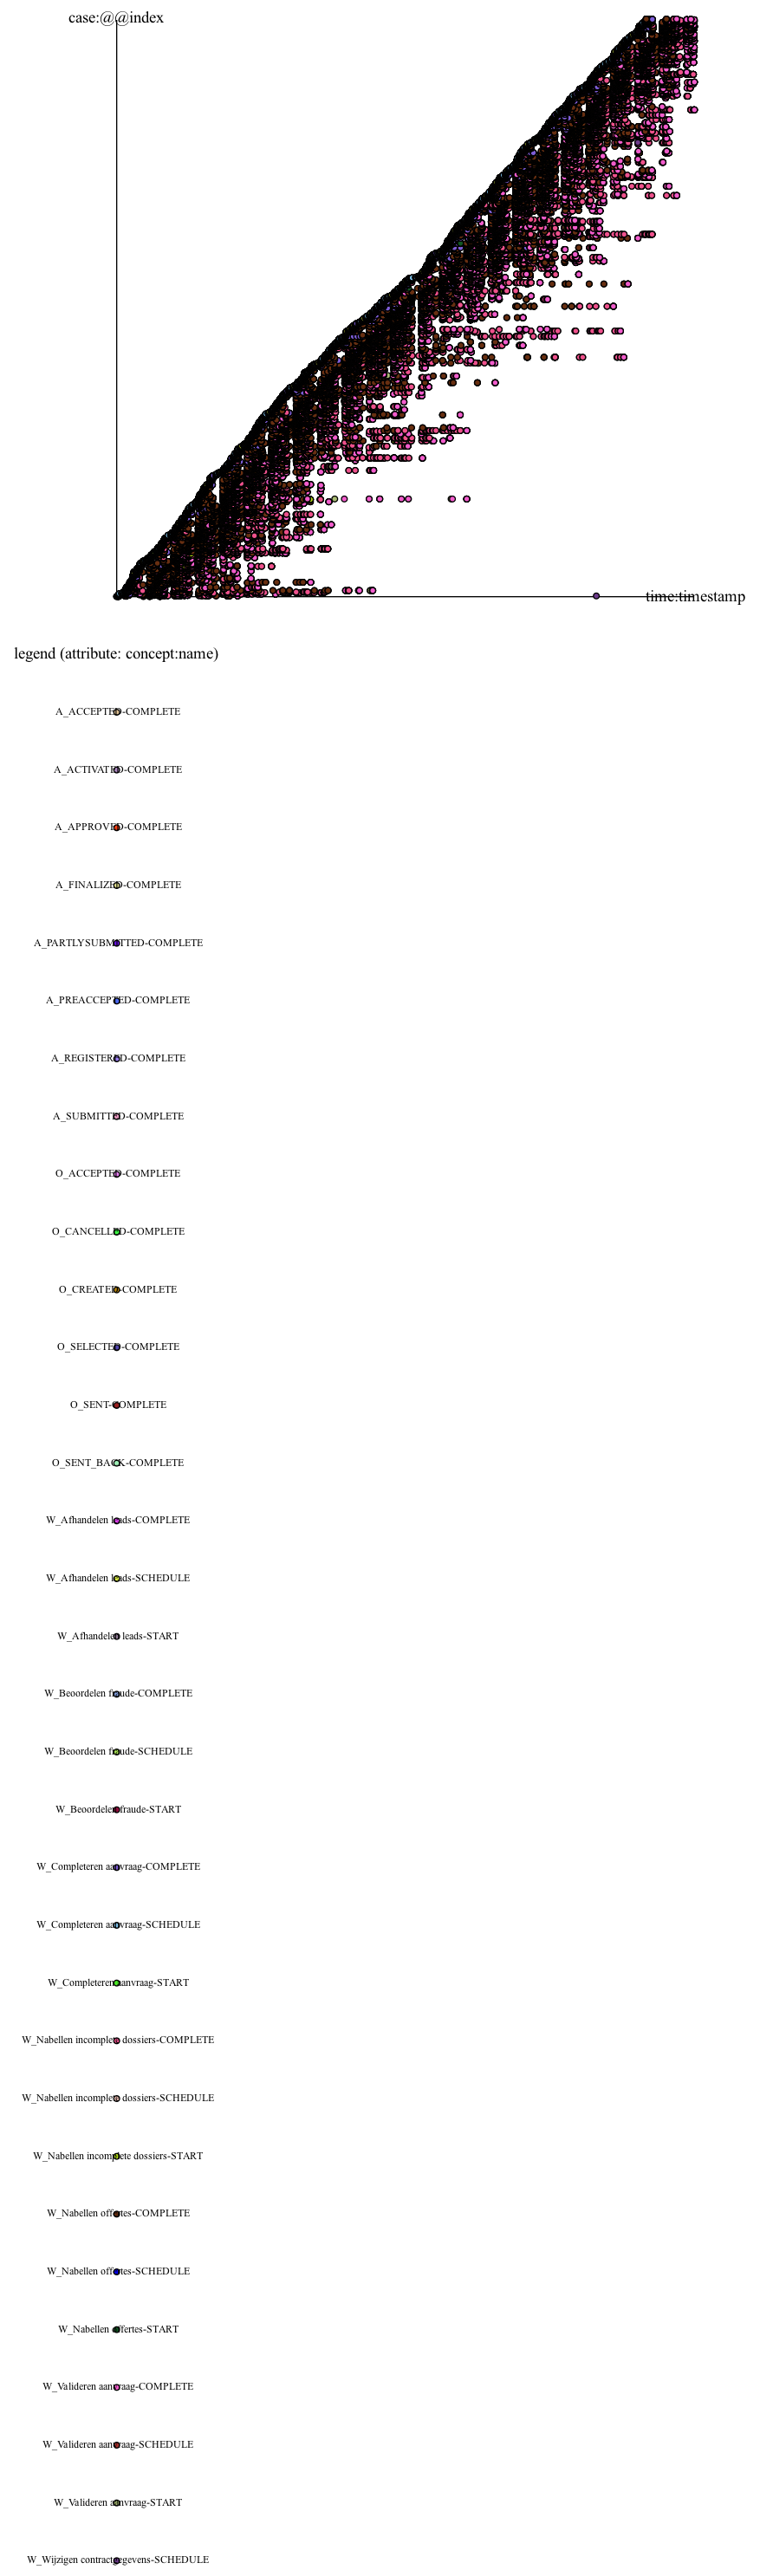

In [206]:
# dotted chart
pm4py.view_dotted_chart(filtered_event_log_S)

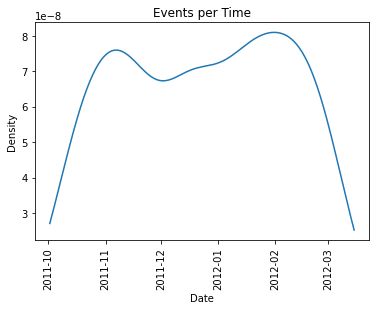

In [207]:
# Events per time - 시간 당 이벤트 정보 
pm4py.view_events_per_time_graph(filtered_event_log_S)

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


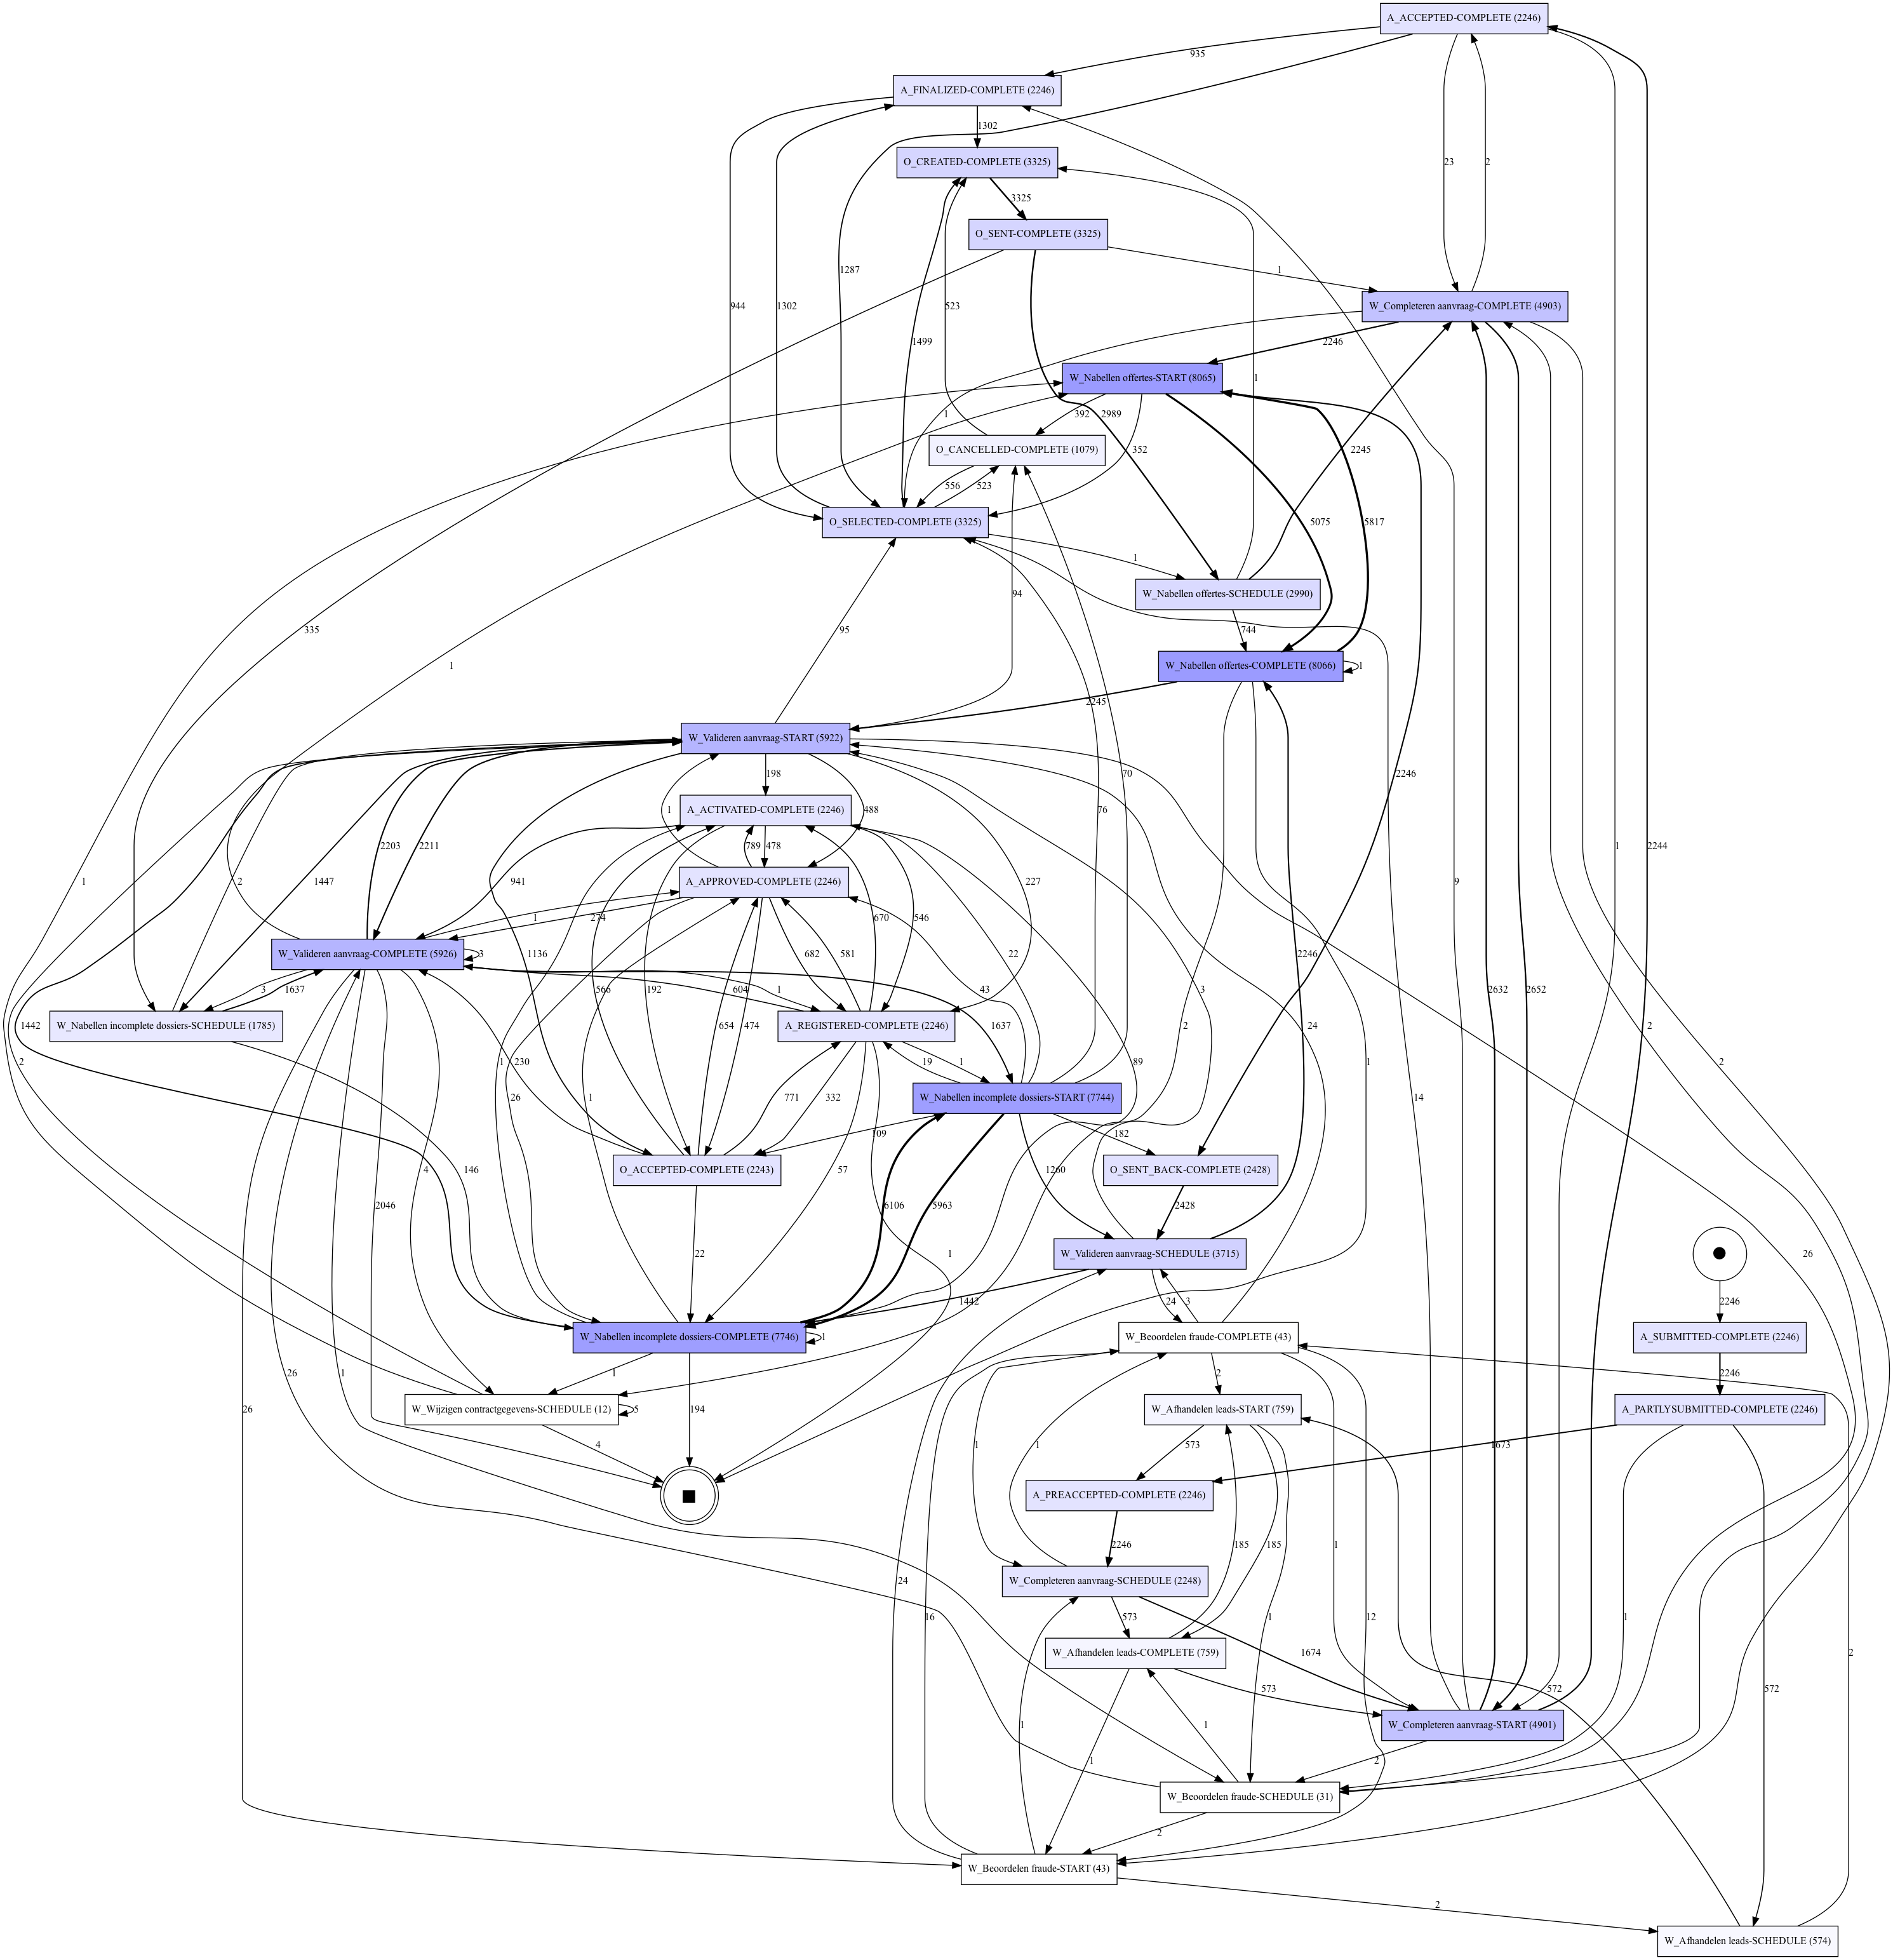

In [208]:
# DFG
rel, start, final = pm4py.discover_dfg(filtered_event_log_S)
pm4py.view_dfg(rel, start, final)

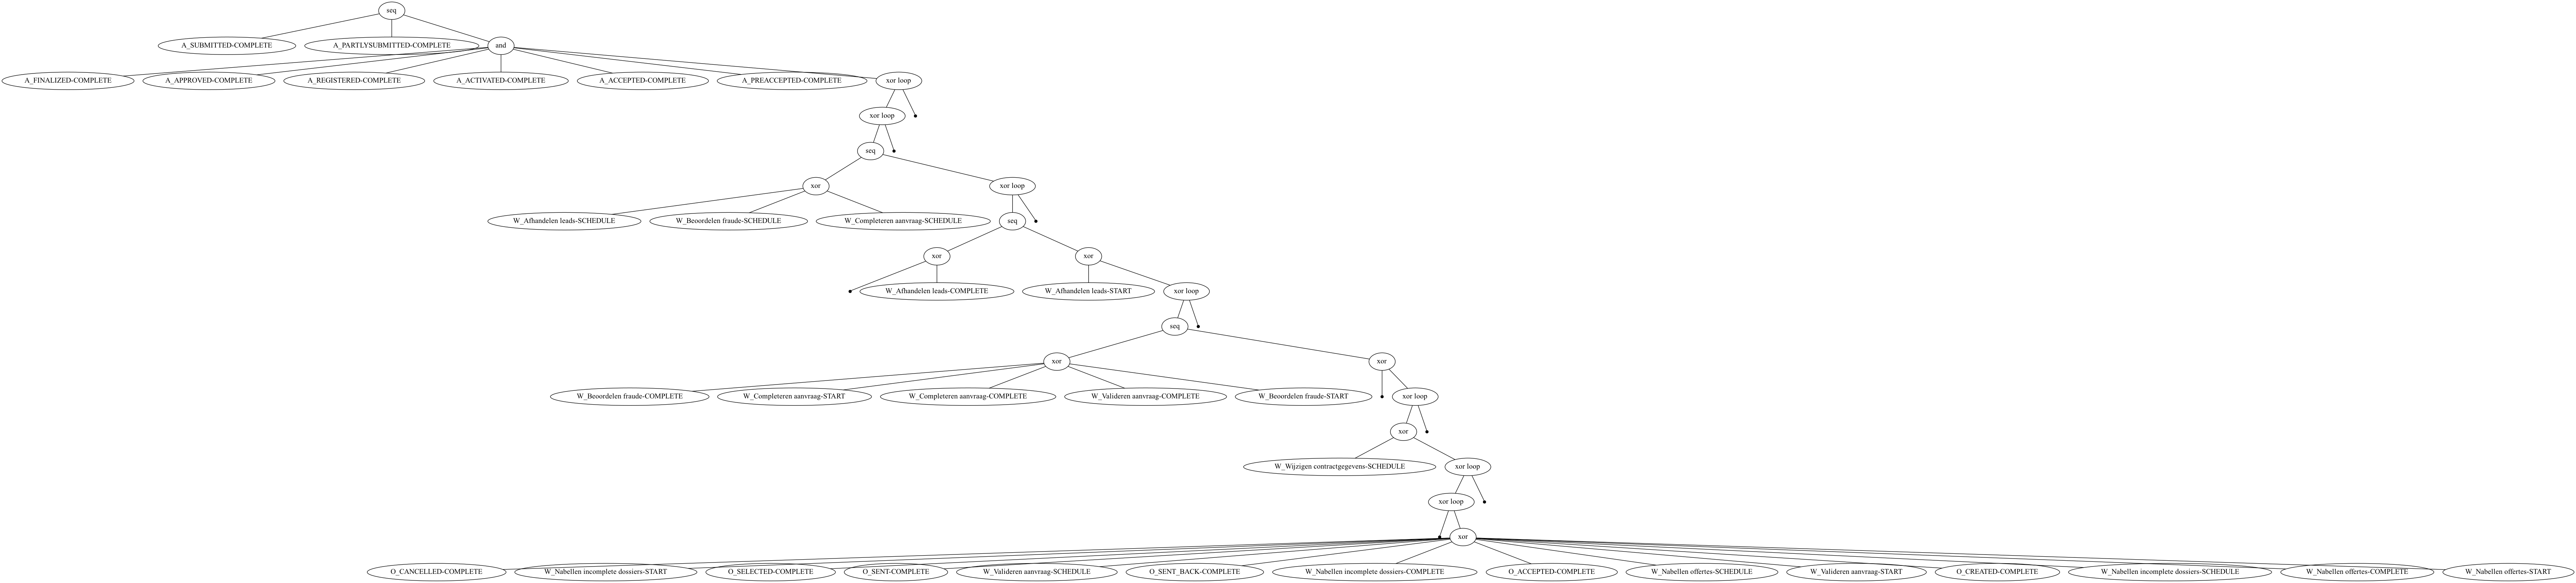

In [23]:
# Inductive Mining (Process tree)
tree = pm4py.discover_process_tree_inductive(filtered_event_log_S)
pm4py.view_process_tree(tree)

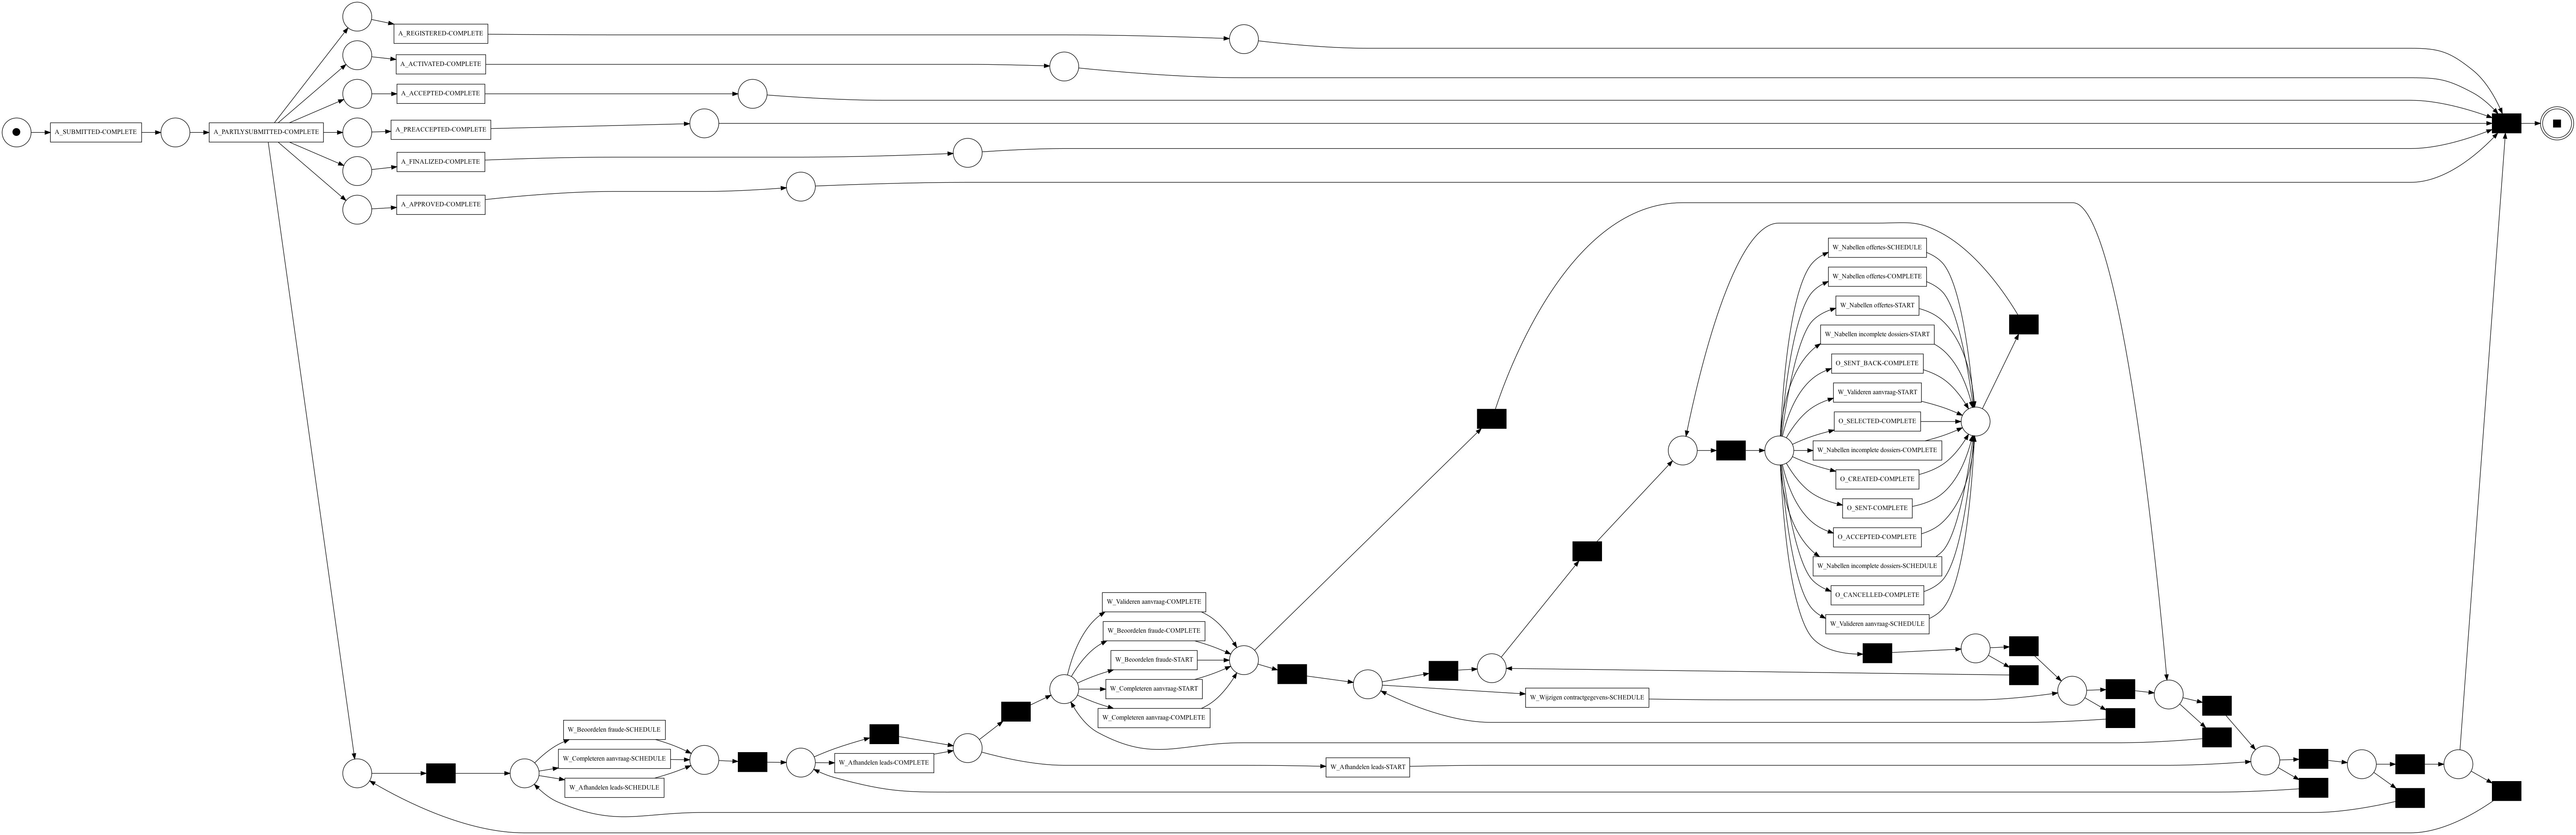

In [24]:
# Inductive mining (Petri-net)
net3, im3, fm3 = pm4py.discover_petri_net_inductive(filtered_event_log_S)
pm4py.view_petri_net(net3, im3, fm3)

## 거절됐을 경우

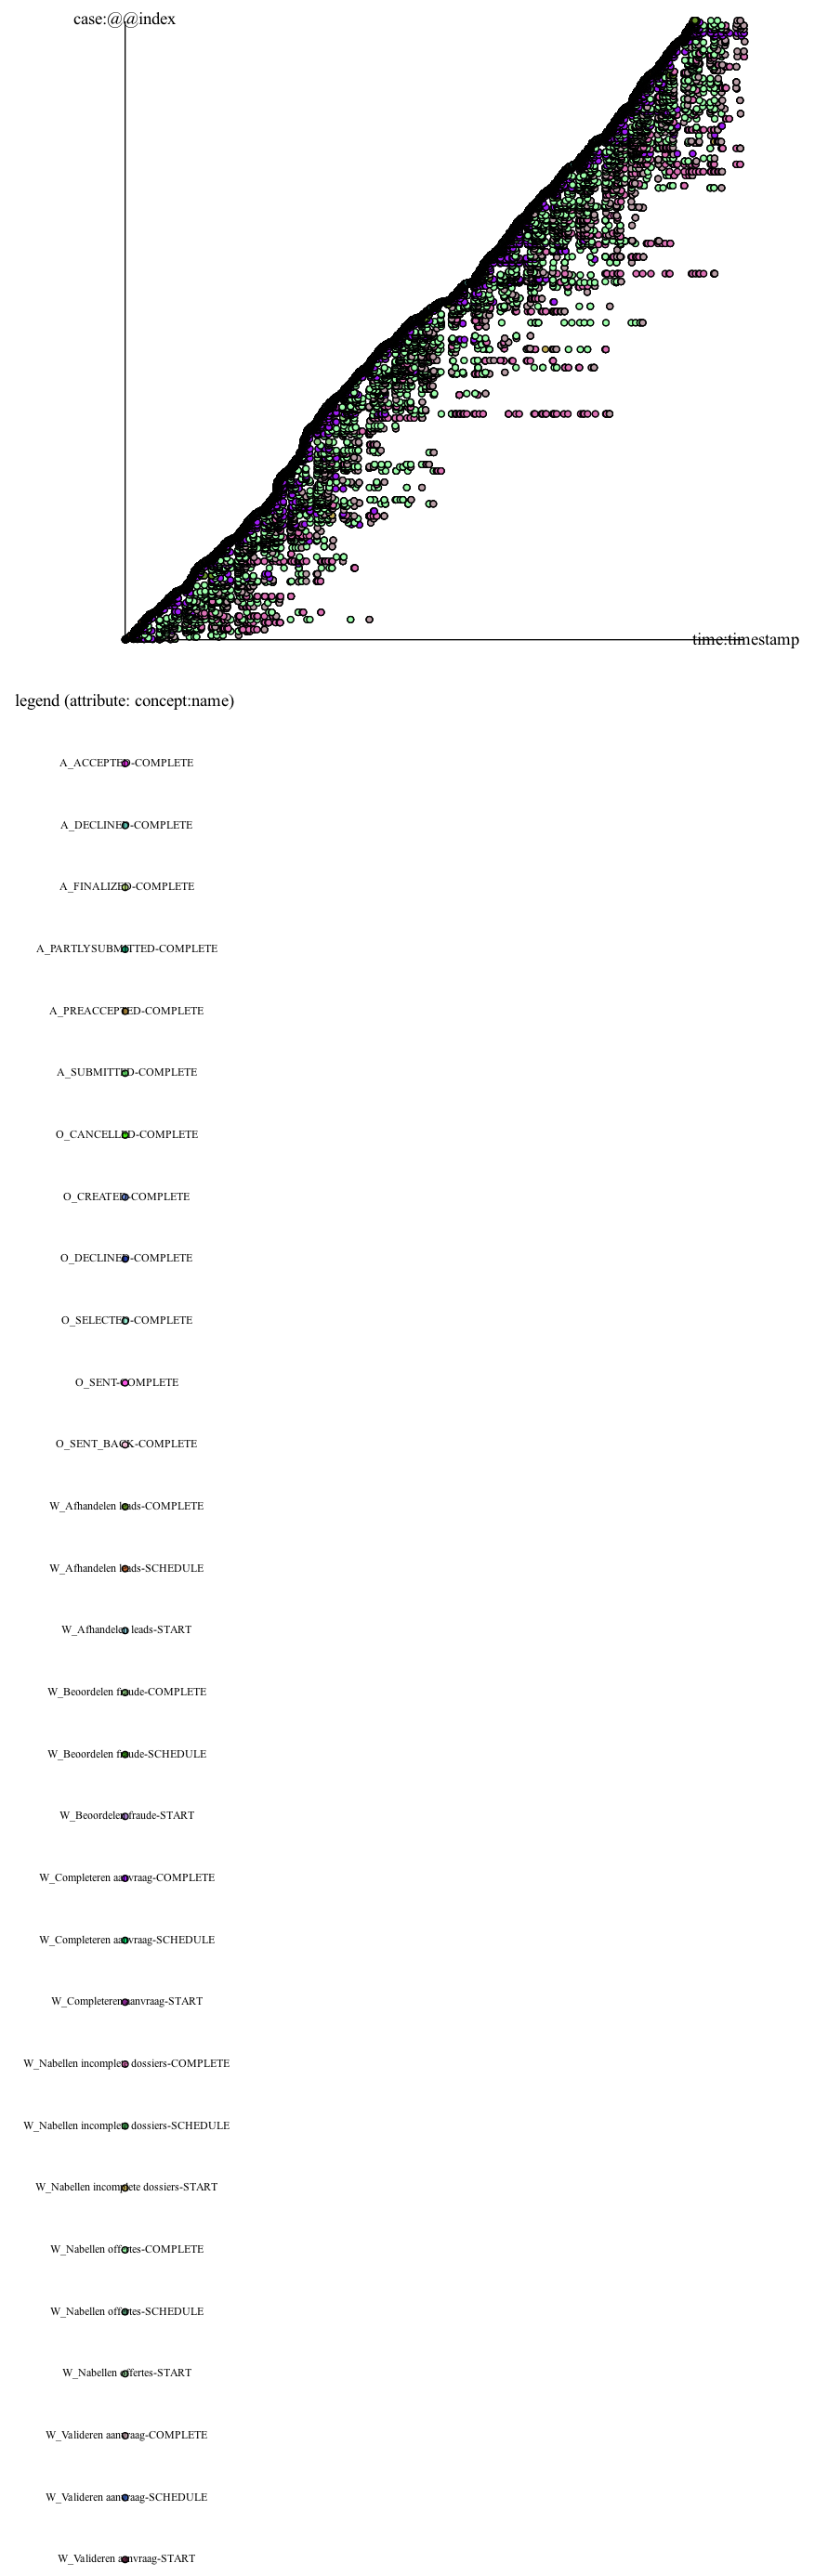

In [209]:
# dotted chart
pm4py.view_dotted_chart(filtered_event_log_D)

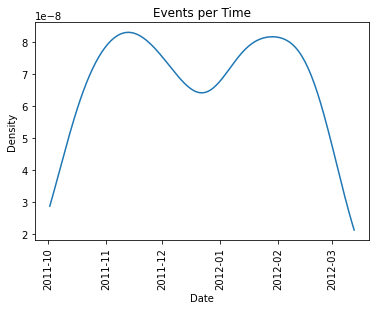

In [210]:
# Events per time - 시간 당 이벤트 정보 
pm4py.view_events_per_time_graph(filtered_event_log_D)

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


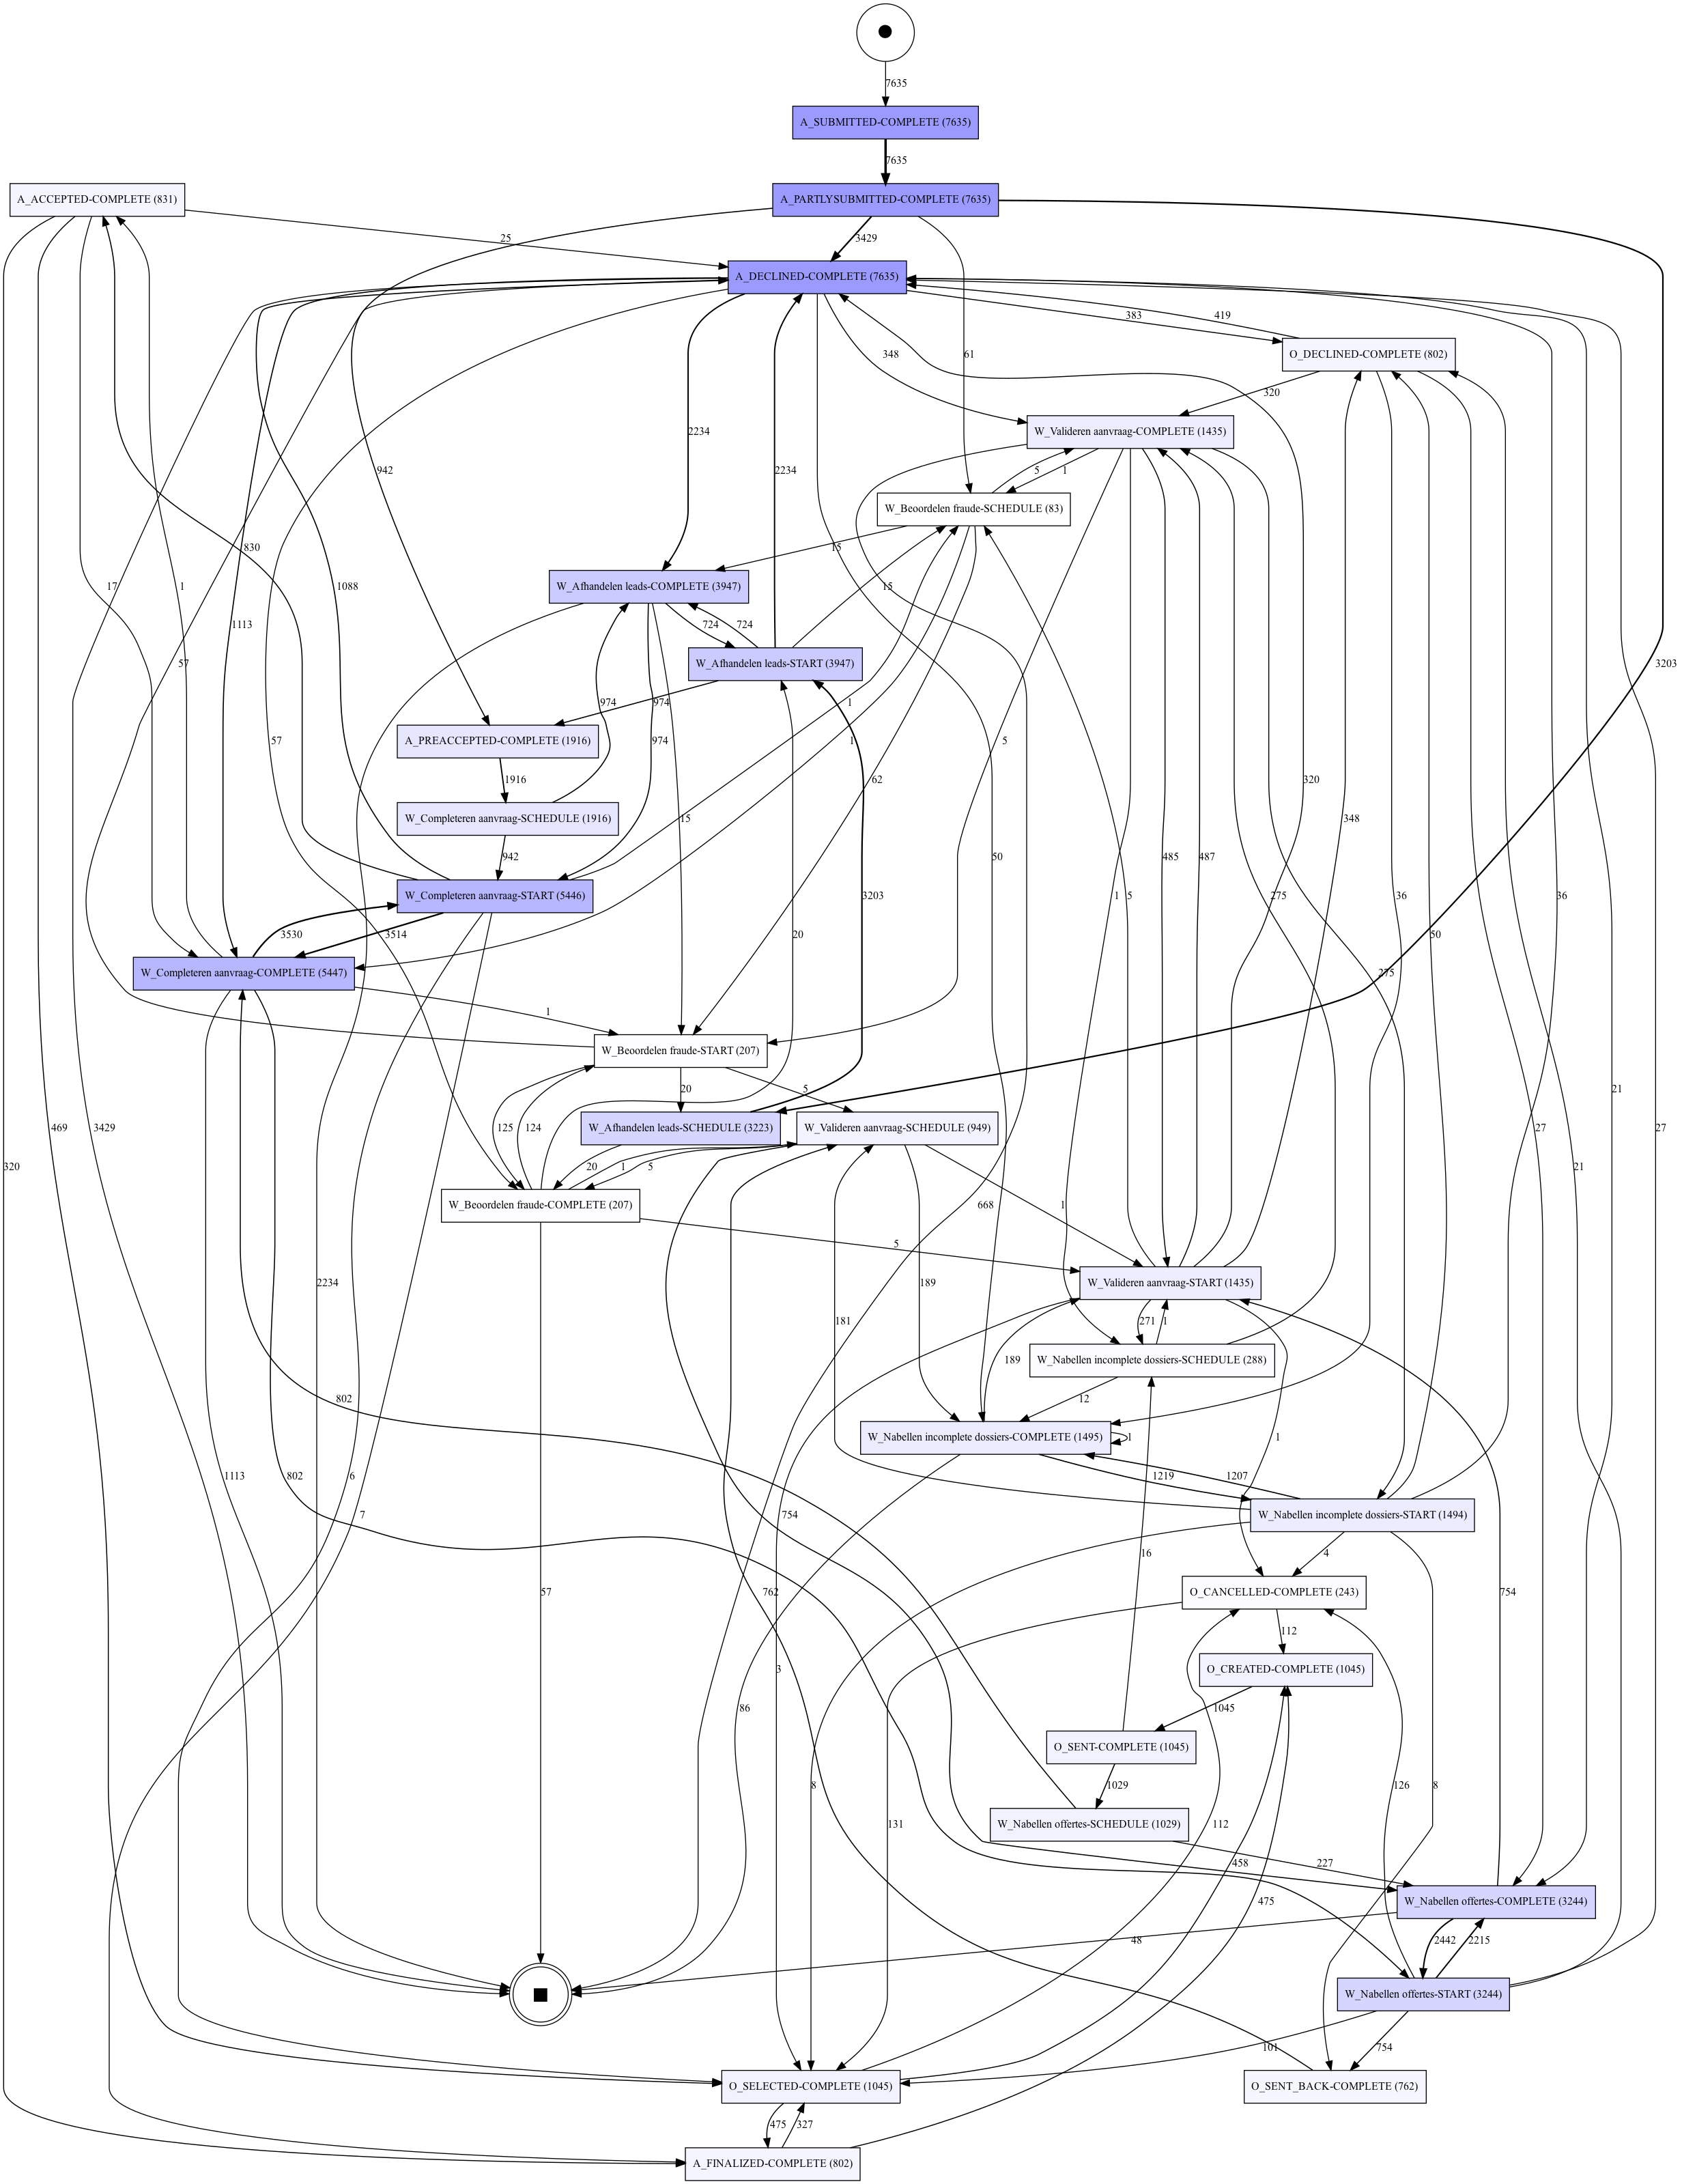

In [211]:
# DFG
rel, start, final = pm4py.discover_dfg(filtered_event_log_D)
pm4py.view_dfg(rel, start, final)

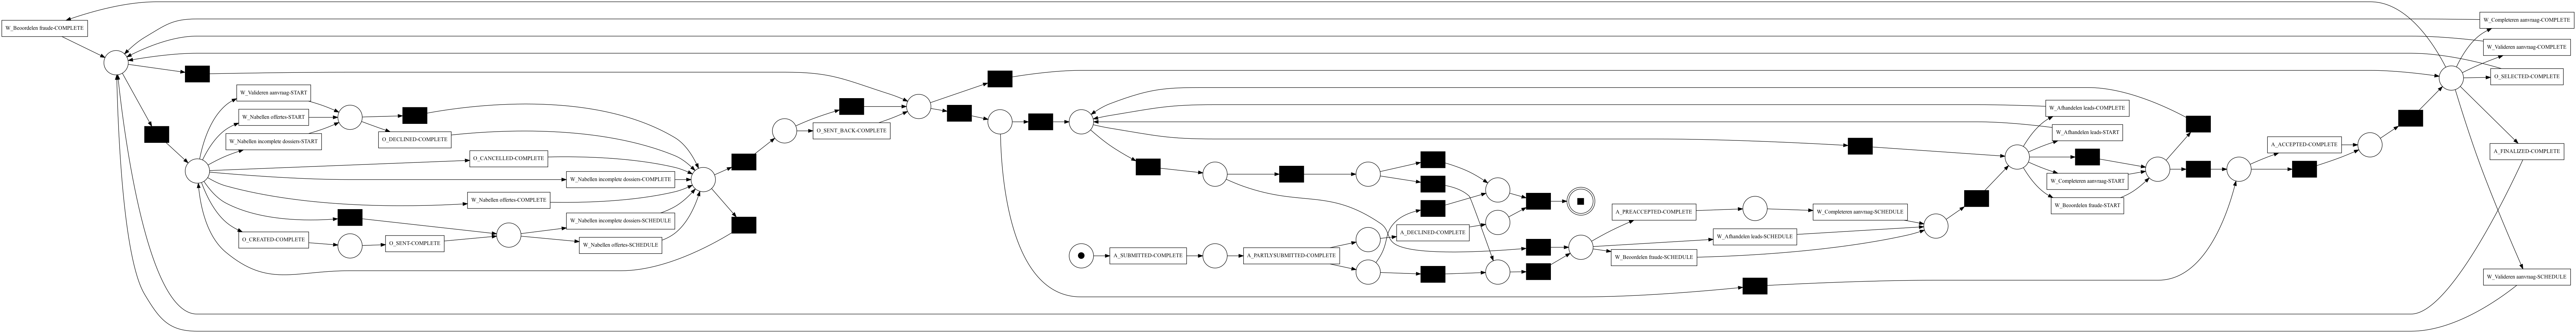

In [30]:
# Inductive mining (Petri-net)
net3, im3, fm3 = pm4py.discover_petri_net_inductive(filtered_event_log_D)
pm4py.view_petri_net(net3, im3, fm3)

## (4) 대출 신청 승인의 결과를 이끄는 주요한 요인은 무엇입니까?

## EDA (Dotted Chart)

In [ ]:
# dotted chart
pm4py.view_dotted_chart(filtered_event_log)

In [ ]:
# performance spectrum - 시간 정보 
pm4py.view_performance_spectrum(event_log_pm4py, ['A_DECLINED-COMPLETE', 'W_Valideren aanvraag-COMPLETE', 'W_Afhandelen leads-COMPLETE', 'W_Completeren aanvraag-COMPLETE', 'W_Nabellen offertes-COMPLETE', 'A_CANCELLED-COMPLETE', 'W_Nabellen incomplete dossiers-COMPLETE', 'O_CANCELLED-COMPLETE', 'W_Beoordelen fraude-COMPLETE', 'W_Wijzigen contractgegevens-SCHEDULE', 'W_Valideren aanvraag-START', 'W_Nabellen offertes-START'])

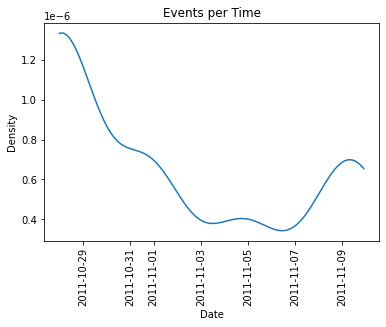

In [ ]:
# Events per time - 시간 당 이벤트 정보 
pm4py.view_events_per_time_graph(filtered_event_log)

## Process Discovery

In [ ]:
# DFG
pm4py.discover_dfg(filtered_event_log)

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


({('A_ACCEPTED-COMPLETE', 'O_SELECTED-COMPLETE'): 1,
  ('A_ACTIVATED-COMPLETE', 'A_REGISTERED-COMPLETE'): 1,
  ('A_APPROVED-COMPLETE', 'A_ACTIVATED-COMPLETE'): 1,
  ('A_FINALIZED-COMPLETE', 'O_CREATED-COMPLETE'): 1,
  ('A_PARTLYSUBMITTED-COMPLETE', 'A_PREACCEPTED-COMPLETE'): 1,
  ('A_PREACCEPTED-COMPLETE', 'W_Completeren aanvraag-SCHEDULE'): 1,
  ('A_SUBMITTED-COMPLETE', 'A_PARTLYSUBMITTED-COMPLETE'): 1,
  ('O_CANCELLED-COMPLETE', 'O_CREATED-COMPLETE'): 1,
  ('O_CREATED-COMPLETE', 'O_SENT-COMPLETE'): 2,
  ('O_SELECTED-COMPLETE', 'A_FINALIZED-COMPLETE'): 1,
  ('O_SELECTED-COMPLETE', 'O_CANCELLED-COMPLETE'): 1,
  ('O_SENT-COMPLETE', 'W_Nabellen offertes-SCHEDULE'): 2,
  ('O_SENT_BACK-COMPLETE', 'W_Valideren aanvraag-SCHEDULE'): 1,
  ('W_Completeren aanvraag-COMPLETE', 'W_Nabellen offertes-START'): 1,
  ('W_Completeren aanvraag-SCHEDULE', 'W_Completeren aanvraag-START'): 1,
  ('W_Completeren aanvraag-START', 'A_ACCEPTED-COMPLETE'): 1,
  ('W_Nabellen offertes-COMPLETE', 'W_Nabellen offerte

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


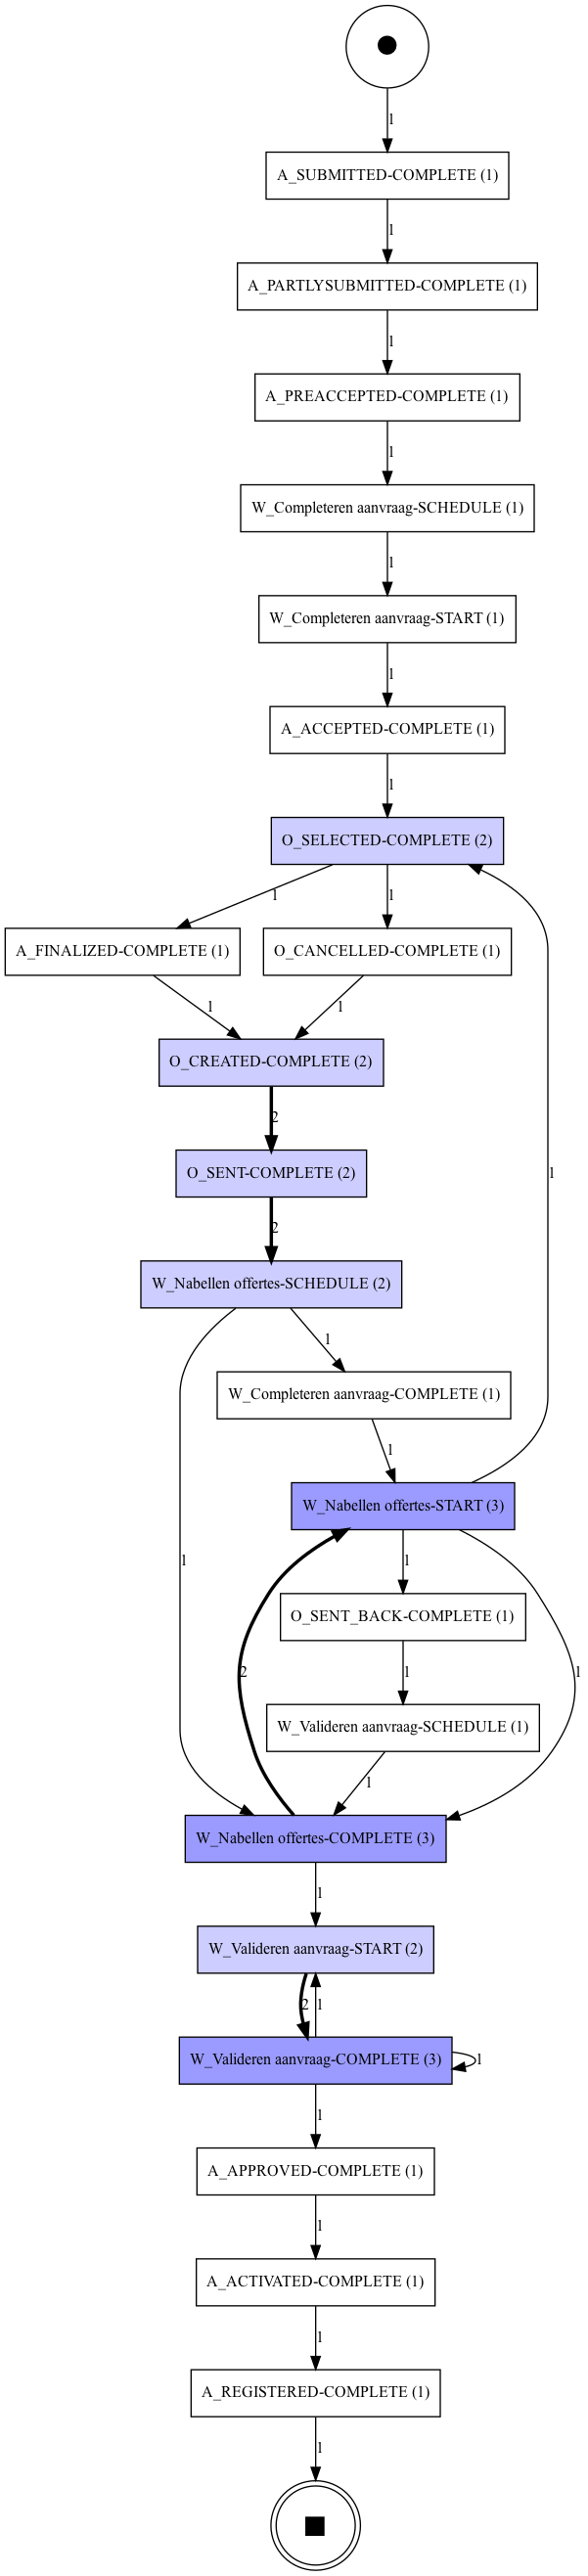

In [ ]:
# DFG
rel, start, final = pm4py.discover_dfg(filtered_event_log)
pm4py.view_dfg(rel, start, final)

/Users/son/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


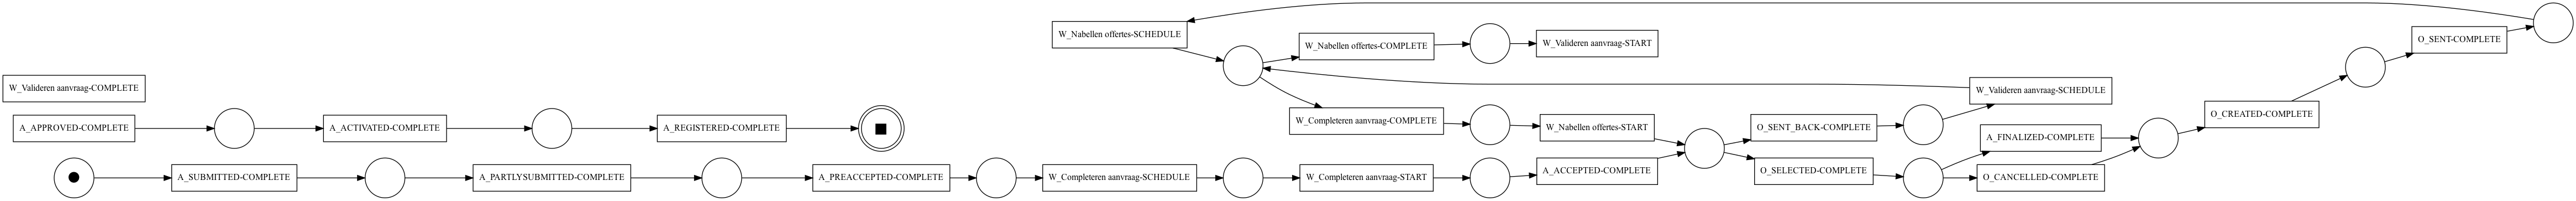

In [ ]:
# Alpha mining (Petri-net)
net, im, fm = pm4py.discover_petri_net_alpha(filtered_event_log)
pm4py.view_petri_net(net, im, fm)

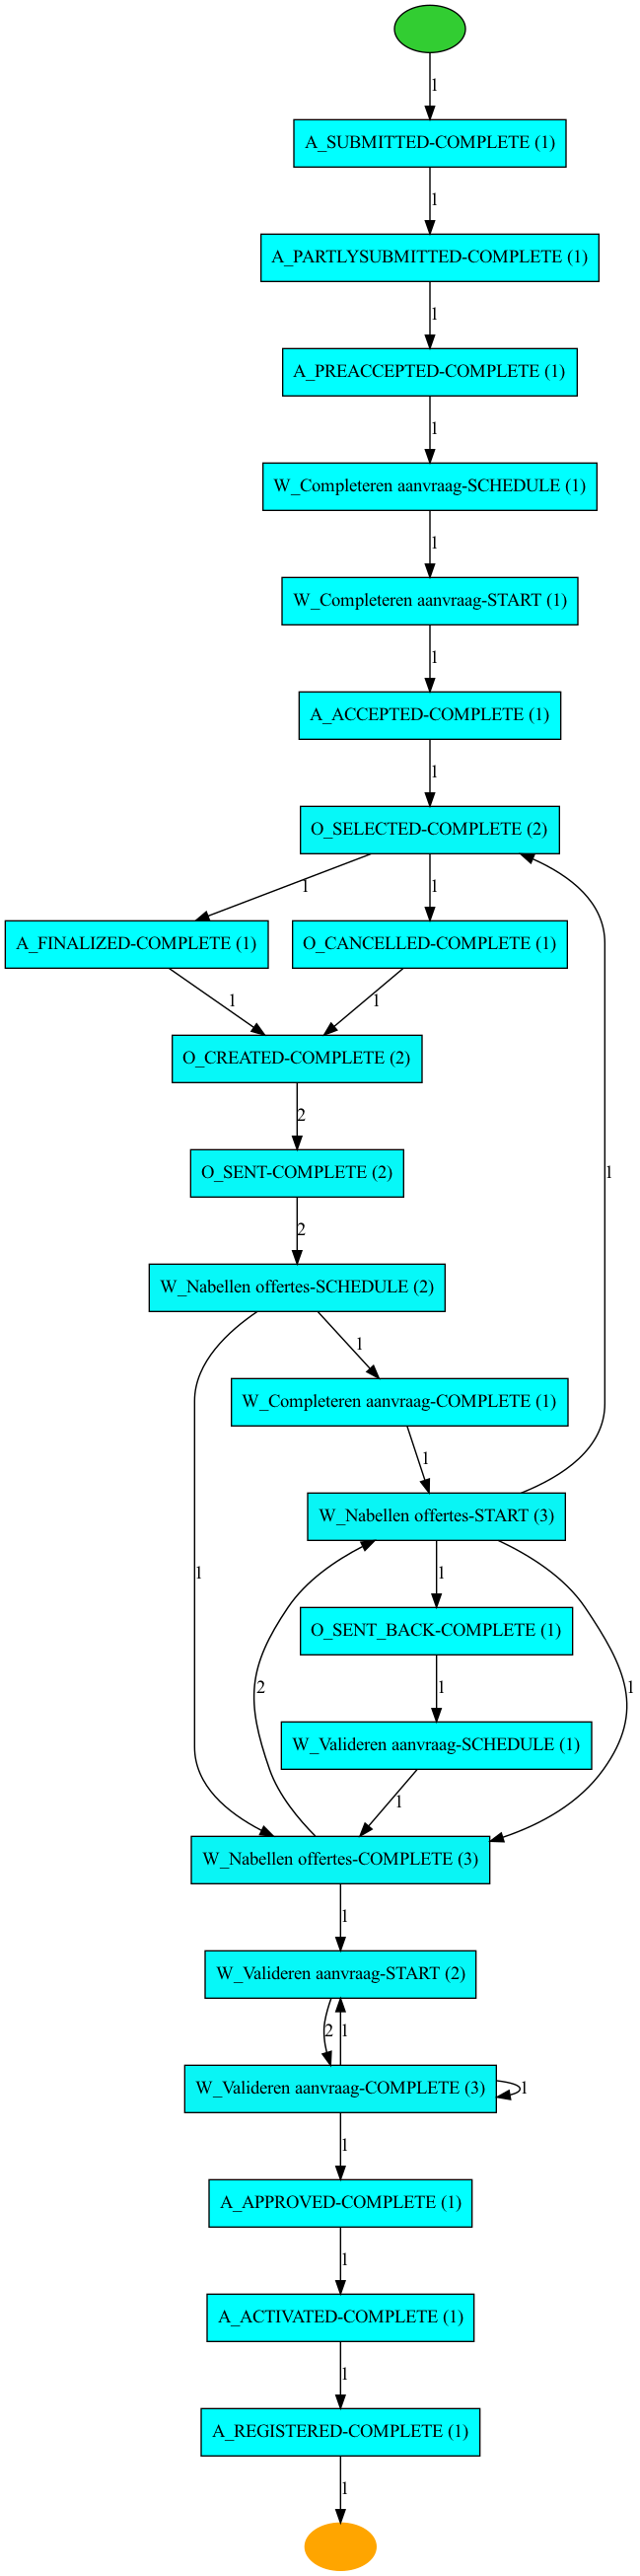

In [ ]:
# Heuristic Mining (Heuristic Net)
heu_model = pm4py.discover_heuristics_net(filtered_event_log)
pm4py.view_heuristics_net(heu_model)

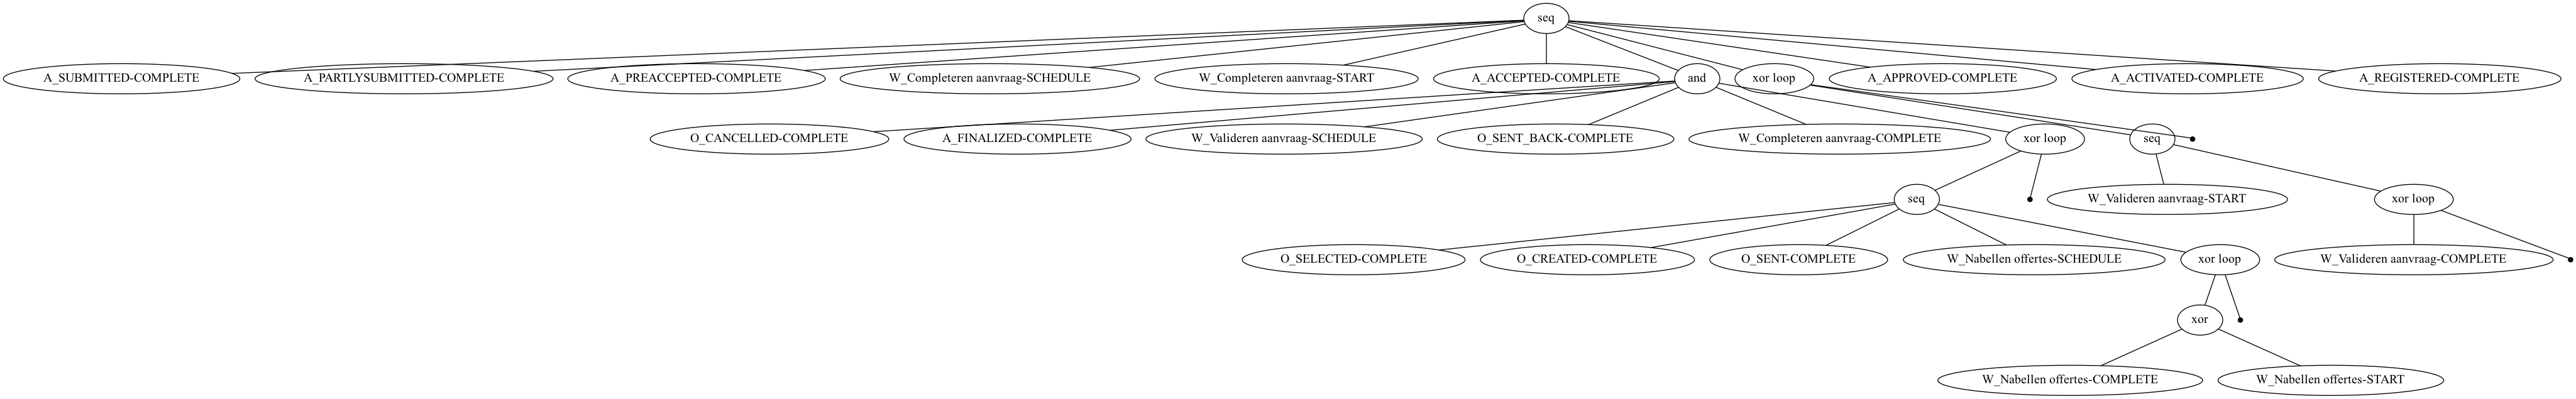

In [ ]:
# Inductive Mining (Process tree)
tree = pm4py.discover_process_tree_inductive(filtered_event_log)
pm4py.view_process_tree(tree)

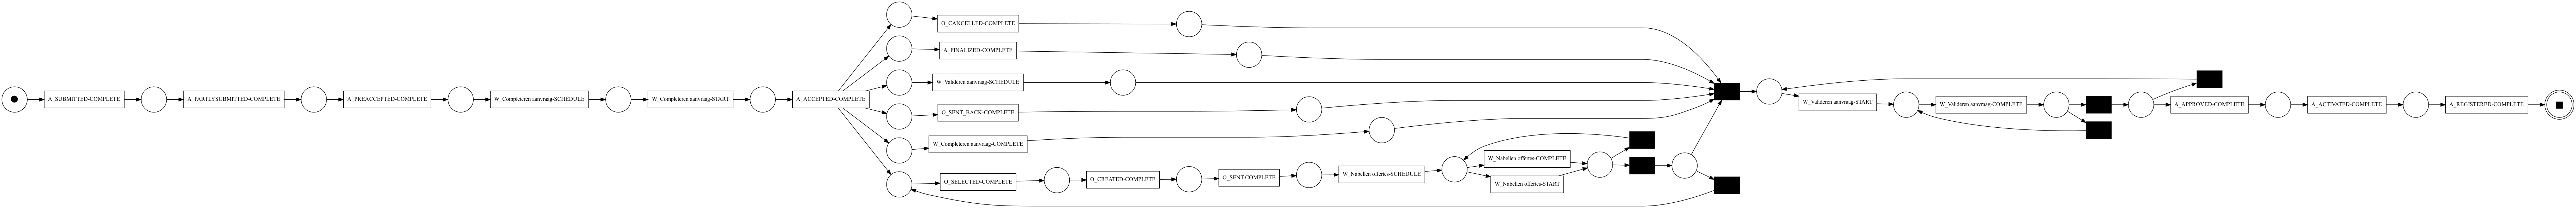

In [ ]:
# Process tree to petri-net
net2, im2, fm2 = pm4py.convert_to_petri_net(tree)
pm4py.view_petri_net(net2, im2, fm2)

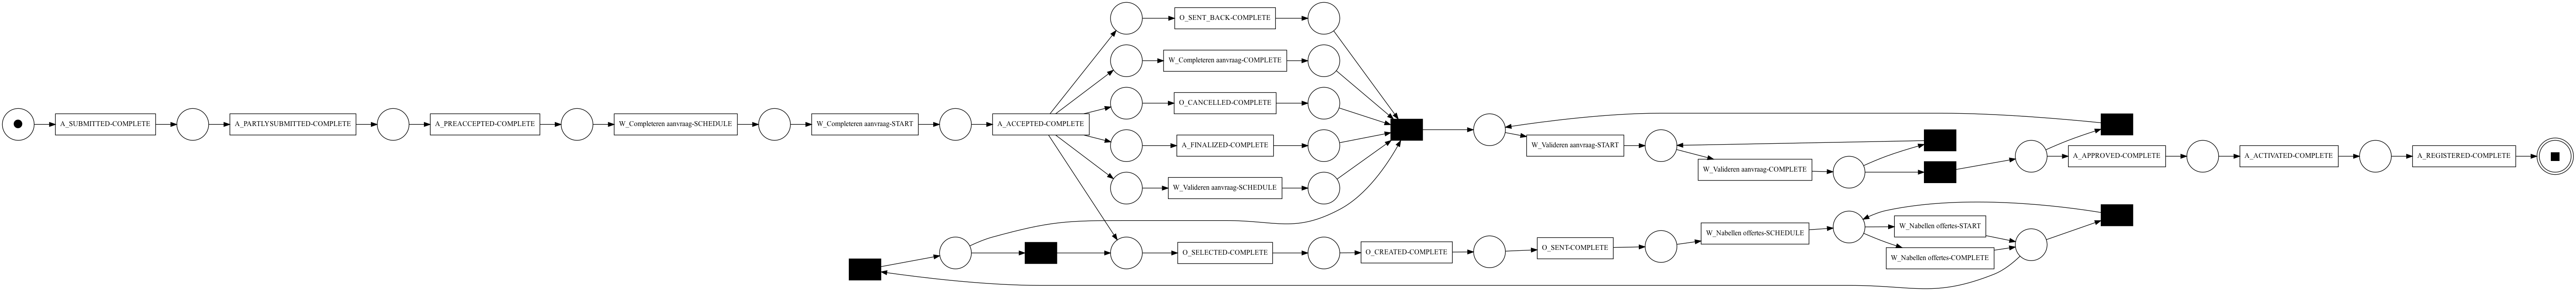

In [ ]:
# Inductive mining (Petri-net)
net3, im3, fm3 = pm4py.discover_petri_net_inductive(filtered_event_log)
pm4py.view_petri_net(net3, im3, fm3)

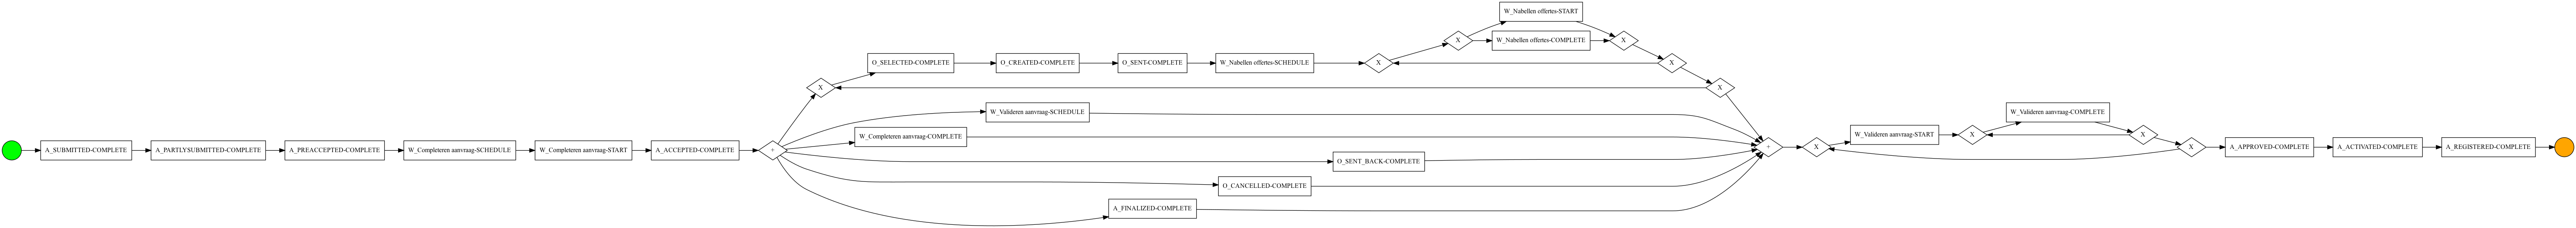

In [ ]:
# Inductive mining (BPMN)
bpmn = pm4py.discover_bpmn_inductive(filtered_event_log)
pm4py.view_bpmn(bpmn)